# Data Processing

In [1]:
!pip install umap-learn
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import pickle
import time
import shap
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score as sklearn_f1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Concatenate, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from collections import Counter
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import cv2
import os
import shutil
import umap.umap_ as umap
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filepath = '/content/drive/My Drive/AI Coursework/Biomarker_Clinical_Data_Images_2.csv'
Data = pd.read_csv(filepath)
Data.columns = Data.columns.str.strip()
Data.head()
disease_label_counts = Data['Disease Label'].value_counts()
print(disease_label_counts)
### Remember Class Imbalance ###

Disease Label
DME    112
DR      80
Name: count, dtype: int64


In [4]:
plt.rcParams.update({
    'font.size': 14,        # Global font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # X and Y label font size
    'xtick.labelsize': 12,  # X-axis tick labels
    'ytick.labelsize': 12,  # Y-axis tick labels
    'legend.fontsize': 12   # Legend font size
})

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Task 1: Supervised Machine Learning, Visualisation, and Feature Importance

## 1-1. Visualisation

### Biomarkers

   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

Text(0, 0.5, 'cumulative explained variance')

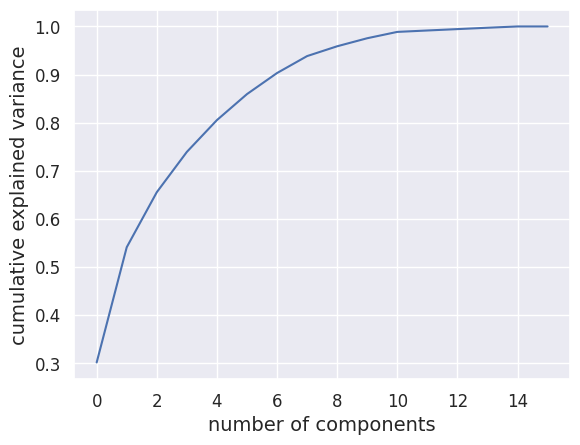

In [6]:
VD = Data.iloc[:,1:17]
print(VD.head())
pca = PCA().fit(VD)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

(192, 16)


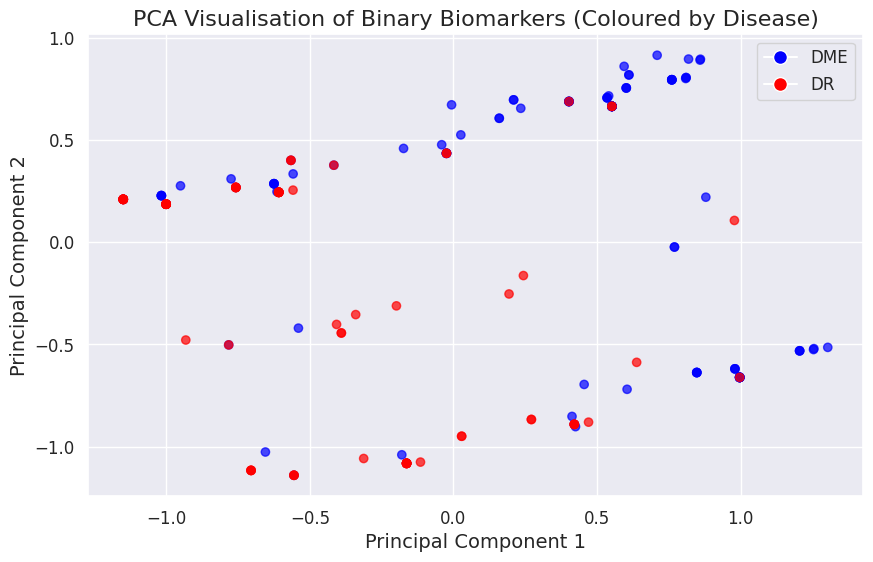

Top Biomarkers for PC1:
Biomarker 12    0.584153
Biomarker 11    0.576206
Biomarker 5     0.392331
Biomarker 6     0.227287
Biomarker 7     0.217947
Name: PC1, dtype: float64

Top Biomarkers for PC2:
Biomarker 7     0.687963
Biomarker 6     0.637519
Biomarker 11    0.229529
Biomarker 12    0.190815
Biomarker 13    0.129969
Name: PC2, dtype: float64


In [7]:
DR = Data.iloc[:,1:17]
print(DR.shape)
labels = Data['Disease Label']

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(DR)

# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping
colormap = {'DME': 'blue', 'DR': 'red'}  # DME in blue, DR in red
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['PCA1'], reduced_df['PCA2'], c=colors, alpha=0.7)
plt.title('PCA Visualisation of Binary Biomarkers (Coloured by Disease)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)
plt.show()

# Get PCA loadings (weights of each biomarker for PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=DR.columns)

# Sort biomarkers by importance in PC1 and PC2
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False)

print("Top Biomarkers for PC1:")
print(top_pc1.head())

print("\nTop Biomarkers for PC2:")
print(top_pc2.head())

Dataset shape: (192, 16)


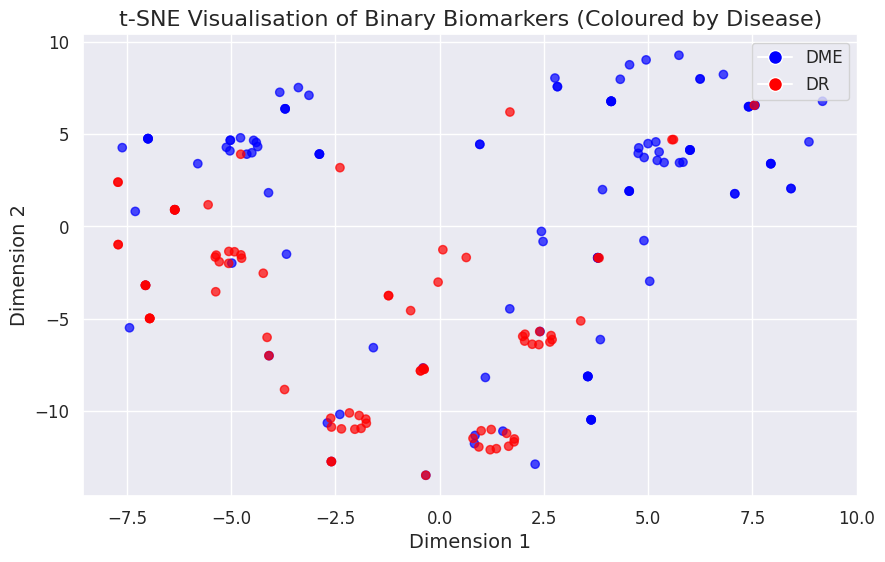

In [8]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(DR)  # Apply t-SNE on biomarker features
print(f"Dataset shape: {DR.shape}")
# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('t-SNE Visualisation of Binary Biomarkers (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset shape: (192, 16)


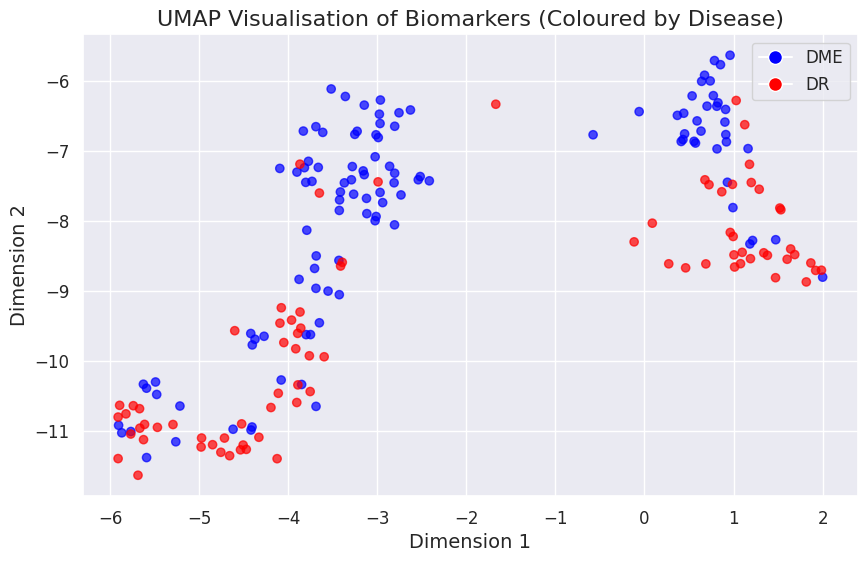

In [9]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(VD)  # Apply UMAP on biomarker features

print(f"Dataset shape: {VD.shape}")

# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('UMAP Visualisation of Biomarkers (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)

save_path = "/content/drive/My Drive/AI Coursework/UMAP_Biomarkers.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

### Clinical Labels

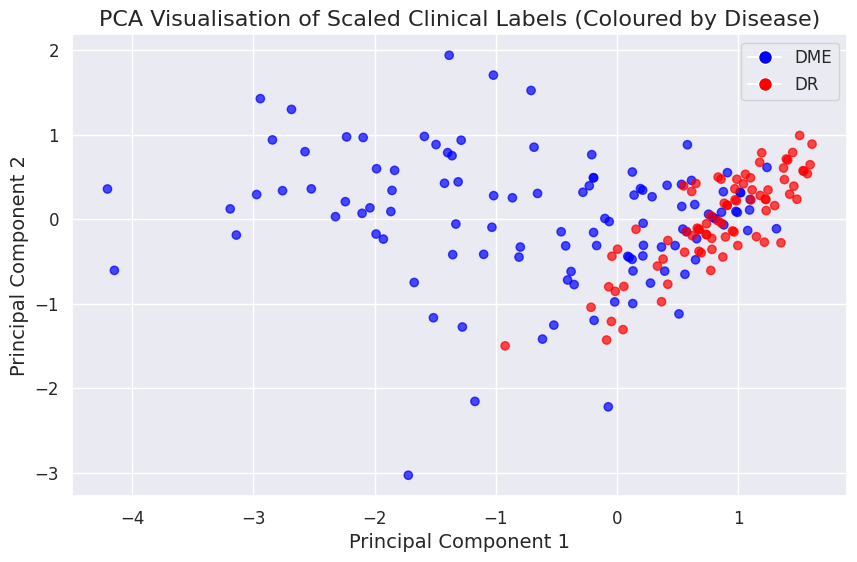

Top Biomarkers for PC1:
BCVA    0.707107
CST     0.707107
Name: PC1, dtype: float64

Top Biomarkers for PC2:
CST     0.707107
BCVA    0.707107
Name: PC2, dtype: float64


In [10]:
CLDR = Data.iloc[:,18:20]
scaler = StandardScaler()
clinical_data_scaled = scaler.fit_transform(CLDR)  # Standardises each feature
labels = Data['Disease Label']

# Apply PCA on the scaled data
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clinical_data_scaled)

# Convert to DataFrame for plotting
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualise PCA Output
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=colors, alpha=0.7)
plt.title('PCA Visualisation of Scaled Clinical Labels (Coloured by Disease)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')
])
plt.grid(True)
plt.show()

# Get PCA loadings (weights of each biomarker for PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=CLDR.columns)

# Sort biomarkers by importance in PC1 and PC2
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False)

print("Top Biomarkers for PC1:")
print(top_pc1.head())

print("\nTop Biomarkers for PC2:")
print(top_pc2.head())

Dataset shape: (192, 2)


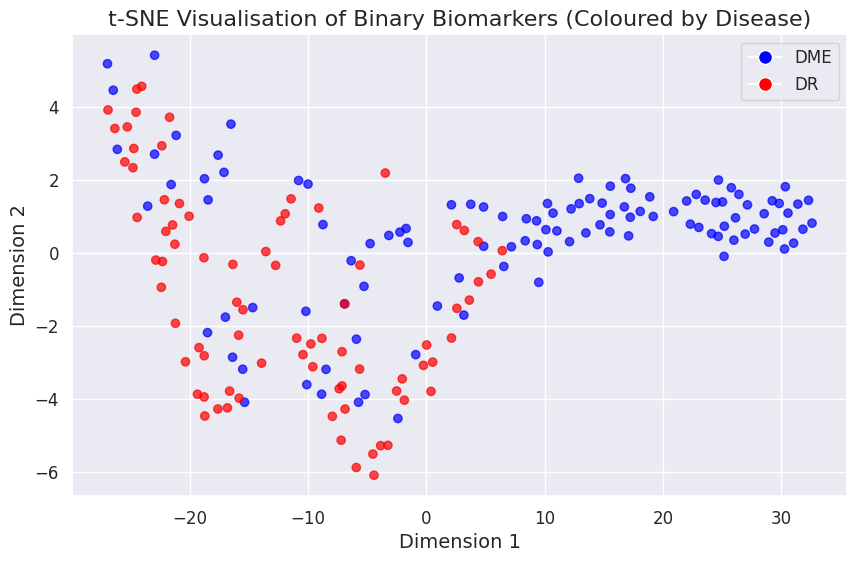

In [11]:
scaler = StandardScaler()
clinical_data_scaled = scaler.fit_transform(CLDR)  # Standardises each feature# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
reduced_data = tsne.fit_transform(CLDR)  # Apply t-SNE on biomarker features
print(f"Dataset shape: {CLDR.shape}")
# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('t-SNE Visualisation of Binary Biomarkers (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset shape: (192, 2)


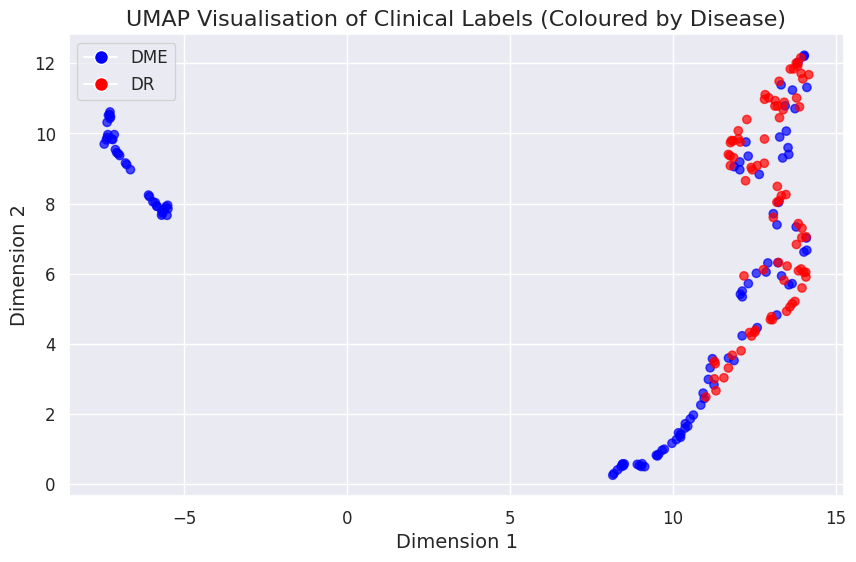

In [12]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(CLDR)  # Apply UMAP on biomarker features

print(f"Dataset shape: {CLDR.shape}")

# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('UMAP Visualisation of Clinical Labels (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)

save_path = "/content/drive/My Drive/AI Coursework/UMAP_Clinical Labels.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

### Combined

   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

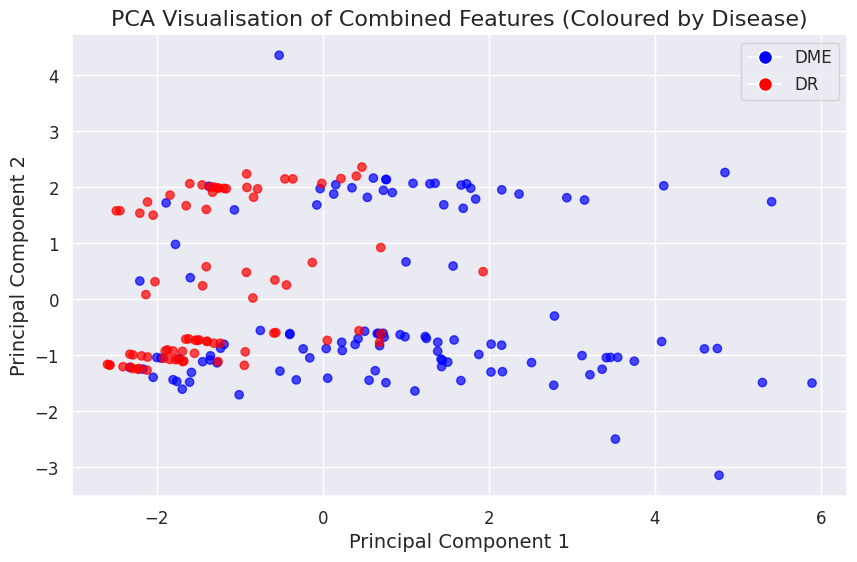

Top Biomarkers for PC1:
CST             0.444660
Biomarker 11    0.421729
Biomarker 12    0.384187
BCVA            0.381579
Biomarker 13    0.373670
Name: PC1, dtype: float64

Top Biomarkers for PC2:
Biomarker 6     0.659451
Biomarker 7     0.654448
Biomarker 8     0.163263
Biomarker 10    0.159003
Biomarker 5     0.130322
Name: PC2, dtype: float64


In [13]:
CDR = Data.iloc[:,1:17].join(Data.iloc[:,18:20])
print(CDR.head())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(CDR)
labels = Data['Disease Label']

# Apply PCA on the scaled data
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Convert to DataFrame for plotting
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualise PCA Output
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=colors, alpha=0.7)
plt.title('PCA Visualisation of Combined Features (Coloured by Disease)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')
])
plt.grid(True)
plt.show()

# Get PCA loadings (weights of each biomarker for PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=CDR.columns)

# Sort biomarkers by importance in PC1 and PC2
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False)

print("Top Biomarkers for PC1:")
print(top_pc1.head())

print("\nTop Biomarkers for PC2:")
print(top_pc2.head())

Dataset shape: (192, 18)


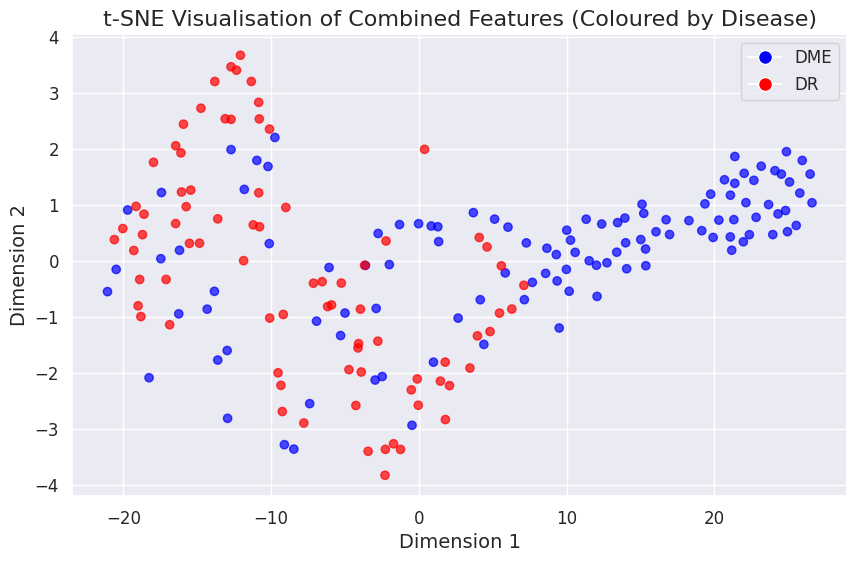

In [14]:
scaler = StandardScaler()
clinical_data_scaled = scaler.fit_transform(CDR)  # Standardises each feature# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=25)
reduced_data = tsne.fit_transform(CDR)  # Apply t-SNE on biomarker features
print(f"Dataset shape: {CDR.shape}")
# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('t-SNE Visualisation of Combined Features (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset shape: (192, 18)


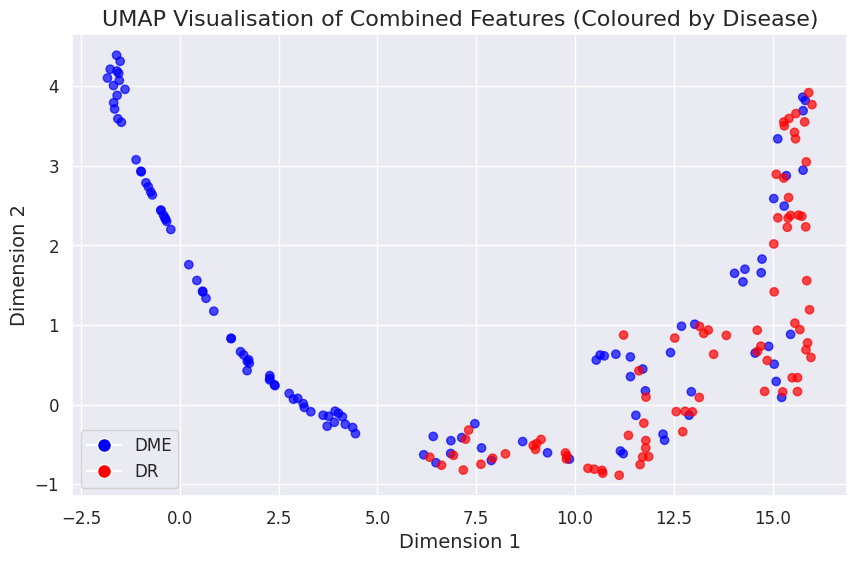

In [15]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(CDR)  # Apply UMAP on biomarker features

print(f"Dataset shape: {CDR.shape}")

# Convert to DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['Disease'] = labels  # Add disease labels

# Colour mapping for disease groups
colormap = {'DME': 'blue', 'DR': 'red'}
colors = reduced_df['Disease'].map(colormap)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['Dim1'], reduced_df['Dim2'], c=colors, alpha=0.7)
plt.title('UMAP Visualisation of Combined Features (Coloured by Disease)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='blue', label='DME'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red', label='DR')])
plt.grid(True)

save_path = "/content/drive/My Drive/AI Coursework/UMAP_Combined Features.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

## 1-2. Selecting Models

### Only Biomarkers - SVM

In [22]:
# Feature selection (only Biomarkers) and target extraction
X = Data.drop(['Path', 'BCVA', 'CST', 'Disease Label', 'Eye_ID'], axis=1)  # Adjust column names if needed
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification


X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


Train Set Size: 144
Test Set Size: 48
Class Distribution in Train Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Distribution in Test Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Encoding: {'DME': np.int64(0), 'DR': np.int64(1)}
Unique Groups in Train Set: 72
Unique Groups in Test Set: 24
No group leakage between train and test sets!
Number of features in X_train: 16
Number of features in X_test: 16
Feature Means:
Biomarker 1     0.006944
Biomarker 2     0.083333
Biomarker 3     0.006944
Biomarker 4     0.041667
Biomarker 5     0.666667
Biomarker 6     0.291667
Biomarker 7     0.611111
Biomarker 8     0.097222
Biomarker 9     0.263889
Biomarker 10    0.006944
Biomarker 11    0.458333
Biomarker 12    0.562500
Biomarker 13    0.111111
Biomarker 14    0.000000
Biomarker 15    0.000000
Biomarker 16    0.034722
dtype: float64
Feature Standard Deviations:
Biomarker 1     0.083333
Biomarker 2     0.277350
Biomarker 3     0.083333
Biomarker 4

Best Parameters for kernel=rbf: {'C': 3.0, 'gamma': 1.4517241379310346}
Best Cross-Validation F1-macro: 0.8661
Optimal Threshold (Averaged over folds): 0.4832
              precision    recall  f1-score   support

         DME       0.95      0.71      0.82        28
          DR       0.70      0.95      0.81        20

    accuracy                           0.81        48
   macro avg       0.83      0.83      0.81        48
weighted avg       0.85      0.81      0.81        48

Final Test Set F1-macro Score: 0.812


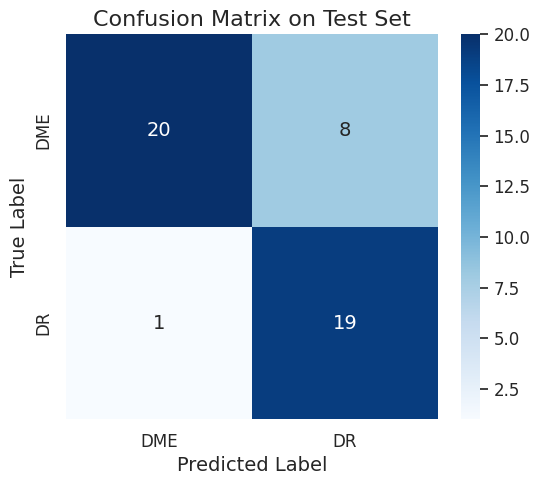

In [23]:
def gridsearch_kernel_optimisation(X_train, y_train, groups_train, kernel, param_grid, scoring='f1_macro'):
    """
    Optimises parameters for a specific SVM kernel using GridSearchCV and finds the optimal threshold.
    Computes the average optimal threshold over all folds instead of taking the best in a single fold.
    """

    param_grid_list = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    best_score = -np.inf
    best_params = None
    best_threshold = None
    best_model = None

    fold = 1  # Initialize fold counter

    for params in param_grid_list:
        cv_scores = []
        thresholds = []  # Store optimal threshold from each fold

        for train_idx, val_idx in skf.split(X_train, y_train, groups_train):

            fold += 1  # Increment fold counter

            X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]



            # Ensure there are two classes in every fold
            if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val)) < 2:
                continue

            model = SVC(probability=True, kernel=kernel, **params,
                         class_weight = 'balanced', random_state=42)
            model.fit(X_train_fold, y_train_fold)

            # Compute Precision-Recall and Optimal Threshold
            y_proba = model.predict_proba(X_val)[:, 1]
            precision, recall, thresholds_fold = precision_recall_curve(y_val, y_proba, pos_label=1)

            f1_scores = np.divide(2 * (precision * recall), (precision + recall),
                                  out=np.zeros_like(precision), where=(precision + recall) != 0)

            optimal_idx = np.argmax(f1_scores) if np.any(f1_scores) else 0
            optimal_threshold = thresholds_fold[optimal_idx] if len(thresholds_fold) > 0 else 0.5
            thresholds.append(optimal_threshold)  # Store threshold from this fold

            y_pred = (y_proba >= optimal_threshold).astype(int)
            f1 = f1_score(y_val, y_pred, average='macro')
            cv_scores.append(f1)

        mean_cv_score = np.mean(cv_scores)
        mean_threshold = np.mean(thresholds)  # Take the average of the 5 folds

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params
            best_threshold = mean_threshold  # Now using the average threshold


            best_model = SVC(probability=True, kernel=kernel, **params,
                              class_weight = 'balanced', random_state=42)
            best_model.fit(X_train, y_train)

    print(f"Best Parameters for kernel={kernel}: {best_params}")
    print(f"Best Cross-Validation F1-macro: {best_score:.4f}")
    print(f"Optimal Threshold (Averaged over folds): {best_threshold:.4f}")

    return best_params, best_threshold, best_model


# Define parameter grids
param_grids = {
    'linear': {'C': np.linspace(0.1, 2.0, 20).tolist()},
    'rbf': {'C': np.linspace(3, 10, 20).tolist(), 'gamma': np.linspace(0.1, 1.5, 30).tolist()},
    'poly': {'C': np.linspace(0.001, 10, 20).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist(), 'degree': [2, 3, 4, 5]},
    'sigmoid': {'C': np.linspace(0.1, 10, 20).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist()}
}

# Define kernel
kernel = 'rbf'

best_params, optimal_threshold, best_model = gridsearch_kernel_optimisation(
    X_train, y_train, groups_train, kernel=kernel, param_grid=param_grids[kernel], scoring='f1_macro'
)


# Get test set probabilities
Y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply optimal threshold
y_pred_optimal = (Y_test_proba >= optimal_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_optimal = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_optimal, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set (rounded to 3 significant figures)
f1_macro_test = f1_score(y_test_labels, y_pred_optimal, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")  #

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_optimal, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Only Clinical Labels - SVM

In [24]:
X = Data[['BCVA', 'CST']]
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Assign Train-Test Sets
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging
print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

# Ensure No Group Leakage
print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

# Check if different input sets have different means/stds
print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

# Cross-validation debugging (Not used for training)
for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


Train Set Size: 144
Test Set Size: 48
Class Distribution in Train Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Distribution in Test Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Encoding: {'DME': np.int64(0), 'DR': np.int64(1)}
Unique Groups in Train Set: 72
Unique Groups in Test Set: 24
No group leakage between train and test sets!
Number of features in X_train: 2
Number of features in X_test: 2
Feature Means:
BCVA     77.944444
CST     334.284722
dtype: float64
Feature Standard Deviations:
BCVA     10.144259
CST     112.886208
dtype: float64
Fold 1:
Train Set: 114 samples
Validation Set: 30 samples
No test samples in validation set.
Fold 2:
Train Set: 116 samples
Validation Set: 28 samples
No test samples in validation set.
Fold 3:
Train Set: 116 samples
Validation Set: 28 samples
No test samples in validation set.
Fold 4:
Train Set: 116 samples
Validation Set: 28 samples
No test samples in validation set.
Fold 5:
Train Set: 114 sa

Best Parameters for kernel=sigmoid: {'C': 3.1206896551724137, 'gamma': 0.26689655172413795}
Best Cross-Validation F1-macro: 0.8370
Optimal Threshold (Averaged over folds): 0.4962
              precision    recall  f1-score   support

         DME       0.78      0.64      0.71        28
          DR       0.60      0.75      0.67        20

    accuracy                           0.69        48
   macro avg       0.69      0.70      0.69        48
weighted avg       0.71      0.69      0.69        48

Final Test Set F1-macro Score: 0.686


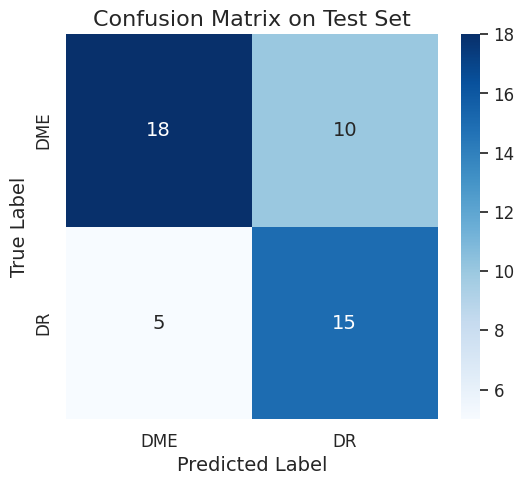

In [25]:
def gridsearch_kernel_optimisation(X_train, y_train, groups_train, kernel, param_grid, scoring='f1_macro'):
    """
    Optimises parameters for a specific SVM kernel using GridSearchCV and finds the optimal threshold.
    Computes the average optimal threshold over all folds instead of taking the best in a single fold.
    """

    param_grid_list = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    best_score = -np.inf
    best_params = None
    best_threshold = None
    best_model = None

    fold = 1  # Initialize fold counter

    for params in param_grid_list:
        cv_scores = []
        thresholds = []  # Store optimal threshold from each fold

        for train_idx, val_idx in skf.split(X_train, y_train, groups_train):

            fold += 1  # Increment fold counter

            X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)  # Fit only on training fold
            X_val_scaled = scaler.transform(X_val)  # Transform validation fold with the same scaler

            # Ensure there are two classes in every fold
            if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val)) < 2:
                continue

            model = SVC(probability=True, kernel=kernel, **params,
                        class_weight='balanced', random_state=42)
            model.fit(X_train_fold_scaled, y_train_fold)

            # Compute Precision-Recall and Optimal Threshold
            y_proba = model.predict_proba(X_val_scaled)[:, 1]
            precision, recall, thresholds_fold = precision_recall_curve(y_val, y_proba, pos_label=1)

            f1_scores = np.divide(2 * (precision * recall), (precision + recall),
                                  out=np.zeros_like(precision), where=(precision + recall) != 0)

            optimal_idx = np.argmax(f1_scores) if np.any(f1_scores) else 0
            optimal_threshold = thresholds_fold[optimal_idx] if len(thresholds_fold) > 0 else 0.5
            thresholds.append(optimal_threshold)  # Store threshold from this fold

            y_pred = (y_proba >= optimal_threshold).astype(int)
            f1 = f1_score(y_val, y_pred, average='macro')
            cv_scores.append(f1)

        mean_cv_score = np.mean(cv_scores)
        mean_threshold = np.mean(thresholds)  # Take the average of the 5 folds

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params
            best_threshold = mean_threshold  # Now using the average threshold

            # Train final model on the full (scaled) training set
            scaler_final = StandardScaler()
            X_train_scaled = scaler_final.fit_transform(X_train)  # Scale full train set
            best_model = SVC(probability=True, kernel=kernel, **params,
                             class_weight='balanced', random_state=42)
            best_model.fit(X_train_scaled, y_train)

    print(f"Best Parameters for kernel={kernel}: {best_params}")
    print(f"Best Cross-Validation F1-macro: {best_score:.4f}")
    print(f"Optimal Threshold (Averaged over folds): {best_threshold:.4f}")

    return best_params, best_threshold, best_model, scaler_final  # Return the scaler


# Define parameter grids
param_grids = {
    'linear': {'C': np.linspace(0.1, 2.0, 20).tolist()},
    'rbf': {'C': np.linspace(0.5, 10, 30).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist()},
    'poly': {'C': np.linspace(0.5, 10, 30).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist(), 'degree': [2, 3, 4, 5]},
    'sigmoid': {'C': np.linspace(0.5, 10, 30).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist()}
}

# Define kernel
kernel = 'sigmoid'

# Perform grid search (WITHOUT pre-scaling X_train)
best_params, optimal_threshold, best_model, trained_scaler = gridsearch_kernel_optimisation(
    X_train, y_train, groups_train, kernel=kernel, param_grid=param_grids[kernel], scoring='f1_macro'
)

# Scale the test set using the trained scaler
X_test_scaled = trained_scaler.transform(X_test)  # Transform test data (DO NOT fit again!)

# Get test set probabilities
Y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Apply optimal threshold
y_pred_optimal = (Y_test_proba >= optimal_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_optimal = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_optimal, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set (rounded to 3 significant figures)
f1_macro_test = f1_score(y_test_labels, y_pred_optimal, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")  # Rounded to 3 significant figures

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_optimal, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Combined - SVM

In [26]:
# Feature & Label Selection
X = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))]  # Select relevant features
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Assign Train-Test Sets
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging
print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

# Ensure No Group Leakage
print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

# Check if different input sets have different means/stds
print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

# Cross-validation debugging (Not used for training)
for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


Train Set Size: 144
Test Set Size: 48
Class Distribution in Train Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Distribution in Test Set:
0    0.583333
1    0.416667
Name: proportion, dtype: float64
Class Encoding: {'DME': np.int64(0), 'DR': np.int64(1)}
Unique Groups in Train Set: 72
Unique Groups in Test Set: 24
No group leakage between train and test sets!
Number of features in X_train: 18
Number of features in X_test: 18
Feature Means:
Biomarker 1       0.006944
Biomarker 2       0.083333
Biomarker 3       0.006944
Biomarker 4       0.041667
Biomarker 5       0.666667
Biomarker 6       0.291667
Biomarker 7       0.611111
Biomarker 8       0.097222
Biomarker 9       0.263889
Biomarker 10      0.006944
Biomarker 11      0.458333
Biomarker 12      0.562500
Biomarker 13      0.111111
Biomarker 14      0.000000
Biomarker 15      0.000000
Biomarker 16      0.034722
BCVA             77.944444
CST             334.284722
dtype: float64
Feature Standard Deviations:


Best Parameters for kernel=sigmoid: {'C': 1.4551724137931035, 'gamma': 0.1789655172413793}
Best Cross-Validation F1-macro: 0.8585
Optimal Threshold (Averaged over folds): 0.4719
              precision    recall  f1-score   support

         DME       0.96      0.82      0.88        28
          DR       0.79      0.95      0.86        20

    accuracy                           0.88        48
   macro avg       0.88      0.89      0.87        48
weighted avg       0.89      0.88      0.88        48

Final Test Set F1-macro Score: 0.874


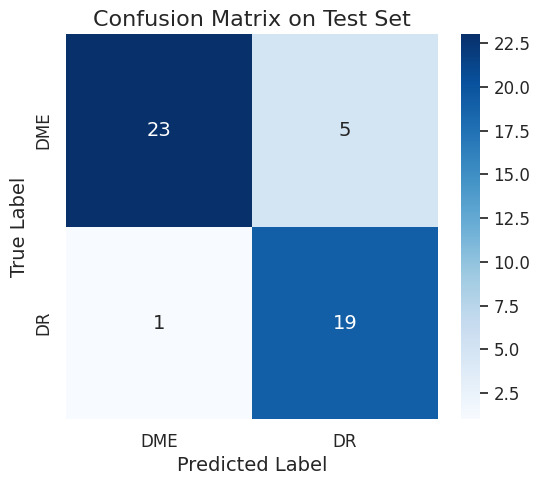

In [27]:
def gridsearch_kernel_optimisation(X_train, y_train, groups_train, kernel, param_grid, scoring='f1_macro'):
    """
    Optimises parameters for a specific SVM kernel using GridSearchCV and finds the optimal threshold.
    Applies selective feature scaling (scales clinical labels only, leaves binary biomarkers untouched).
    """

    # Identify continuous (clinical) and binary (biomarkers) columns
    binary_features = [col for col in Data.columns if "Biomarker" in col]
    continuous_features = ['BCVA', 'CST']

    # ColumnTransformer: Scale continuous features, keep binary as-is
    preprocessor = ColumnTransformer([
        ('scale_continuous', StandardScaler(), continuous_features),
        ('keep_binary', 'passthrough', binary_features)
    ])

    param_grid_list = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    best_score = -np.inf
    best_params = None
    best_threshold = None
    best_model = None

    fold = 1  # Initialize fold counter

    for params in param_grid_list:
        cv_scores = []
        thresholds = []  # Store optimal threshold from each fold

        for train_idx, val_idx in skf.split(X_train, y_train, groups_train):

            fold += 1  # Increment fold counter

            X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Apply selective scaling
            X_train_fold_scaled = preprocessor.fit_transform(X_train_fold)  # Fit only on training fold
            X_val_scaled = preprocessor.transform(X_val)  # Transform validation fold

            # Ensure there are two classes in every fold
            if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val)) < 2:
                continue

            model = SVC(probability=True, kernel=kernel, **params,
                        class_weight='balanced', random_state=42)
            model.fit(X_train_fold_scaled, y_train_fold)

            # Compute Precision-Recall and Optimal Threshold
            y_proba = model.predict_proba(X_val_scaled)[:, 1]
            precision, recall, thresholds_fold = precision_recall_curve(y_val, y_proba, pos_label=1)

            f1_scores = np.divide(2 * (precision * recall), (precision + recall),
                                  out=np.zeros_like(precision), where=(precision + recall) != 0)

            optimal_idx = np.argmax(f1_scores) if np.any(f1_scores) else 0
            optimal_threshold = thresholds_fold[optimal_idx] if len(thresholds_fold) > 0 else 0.5
            thresholds.append(optimal_threshold)  # Store threshold from this fold

            y_pred = (y_proba >= optimal_threshold).astype(int)
            f1 = f1_score(y_val, y_pred, average='macro')
            cv_scores.append(f1)

        mean_cv_score = np.mean(cv_scores)
        mean_threshold = np.mean(thresholds)  # Take the average of the 5 folds

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params
            best_threshold = mean_threshold  # Now using the average threshold

            # Train final model on the full (scaled) training set
            X_train_scaled = preprocessor.fit_transform(X_train)  # Scale full train set
            best_model = SVC(probability=True, kernel=kernel, **params,
                             class_weight='balanced', random_state=42)
            best_model.fit(X_train_scaled, y_train)

    print(f"Best Parameters for kernel={kernel}: {best_params}")
    print(f"Best Cross-Validation F1-macro: {best_score:.4f}")
    print(f"Optimal Threshold (Averaged over folds): {best_threshold:.4f}")

    return best_params, best_threshold, best_model, preprocessor  # Return preprocessor for test scaling



# Define parameter grids
param_grids = {
    'linear': {'C': np.linspace(0.1, 5.0, 25).tolist()},
    'rbf': {'C': np.linspace(0.5, 10, 30).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist()},
    'poly': {'C': np.linspace(0.2, 10, 30).tolist(), 'gamma': np.linspace(0.01, 1.5, 30).tolist(), 'degree': [2, 3, 4, 5]},
    'sigmoid': {'C': np.linspace(0.2, 1.5, 30).tolist(), 'gamma': np.linspace(0.01, 0.5, 30).tolist()}
}

# Define kernel
kernel = 'sigmoid'

# Perform grid search (WITHOUT pre-scaling X_train)
best_params, optimal_threshold, best_model, trained_scaler = gridsearch_kernel_optimisation(
    X_train, y_train, groups_train, kernel=kernel, param_grid=param_grids[kernel], scoring='f1_macro'
)

# Scale the test set using the trained scaler
X_test_scaled = trained_scaler.transform(X_test)  # Transform test data (DO NOT fit again!)
# Get test set probabilities
Y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Apply optimal threshold
y_pred_optimal = (Y_test_proba >= optimal_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_optimal = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_optimal, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set (rounded to 3 significant figures)
f1_macro_test = f1_score(y_test_labels, y_pred_optimal, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")  # Rounded to 3 significant figures

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_optimal, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [28]:
# Train the model and get predicted probabilities
model = SVC(kernel = 'sigmoid', probability=True, C= 1.53, gamma= 0.18, class_weight = 'balanced', random_state=42)

# Use the already trained model (`best_model_rbf`) instead of retraining
#model = best_model_rbf  # Reuse the trained model

# Get predicted probabilities for the positive class (DR) on the test set
y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for DR

# Compute Precision-Recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)

# Compute F1-scores for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
f1_scores = np.nan_to_num(f1_scores)  # Handle NaN values safely

# Plot Precision, Recall, and F1-Score vs Decision Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", marker=".")
plt.plot(thresholds, recall[:-1], label="Recall", marker=".")
plt.plot(thresholds, f1_scores, label="F1-Score", marker=".")
plt.axvline(x=optimal_threshold_rbf, color='r', linestyle='dashed', label=f"Optimal Threshold = {optimal_threshold_rbf:.4f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Decision Threshold (Test Set)")
plt.legend()
plt.grid()
plt.show()

# Print the stored optimal threshold (from training)
print(f"Optimal Threshold Used from Training: {optimal_threshold_rbf}")

# Apply the stored optimal threshold from training
y_pred_optimal = (y_scores >= optimal_threshold_rbf).astype(int)

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Print the Classification Report
report = classification_report(y_test, y_pred_optimal, target_names=["DME", "DR"])
print("Final Classification Report:")
print(report)


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Biomarkers - NN

In [ ]:
# Feature selection (only Biomarkers) and target extraction
X = Data.drop(['Path', 'BCVA', 'CST', 'Disease Label', 'Eye_ID'], axis=1)
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Assign Train-Test Sets
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging
print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

# Ensure No Group Leakage
print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

# Check if different input sets have different means/stds
print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

# Cross-validation debugging (Not used for training)
for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


In [ ]:
def objective(trial):
    # Hyperparameter search space
    n_units = trial.suggest_int('n_units', 16, 128, step=16)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # ADD THRESHOLD SEARCH
    threshold = trial.suggest_float('threshold', 0.3, 0.7, step=0.05)  # Search for best threshold

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        Y_train_cv, Y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]



        # Define model
        model = Sequential([
            Input(shape=(X_train_cv.shape[1],)),
            Dense(n_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(n_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train_cv, Y_train_cv,
                  validation_data=(X_val_cv, Y_val_cv),
                  epochs=20,
                  verbose=0,
                  batch_size=16)

        # Predict probabilities
        y_proba = model.predict(X_val_cv).flatten()

        # APPLY THE OPTIMISED THRESHOLD
        y_pred = (y_proba >= threshold).astype(int)

        # Compute F1-score
        f1 = f1_score(Y_val_cv, y_pred, average='binary')
        fold_f1_scores.append(f1)

    # Return the mean F1-score across folds
    return np.mean(fold_f1_scores)



# Run Optuna optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Retrieve Best Parameters & Threshold
best_params = study.best_params
best_threshold = best_params['threshold']

print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Cross-Validation F1-Score: {study.best_value:.4f}")

# Train Final Neural Network with Best Parameters
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(best_params['n_units'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['n_units'] // 2, activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train on full dataset
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Evaluate Model on Test Set
y_proba_test = model.predict(X_test).flatten()
y_pred_optimal = (y_proba_test >= best_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_labels = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set
f1_macro_test = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Clinical Labels - NN

In [ ]:
X = Data[['BCVA', 'CST']]
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Assign Train-Test Sets
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging
print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

# Ensure No Group Leakage
print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

# Check if different input sets have different means/stds
print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

# Cross-validation debugging (Not used for training)
for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training fold
X_test_scaled = scaler.transform(X_test)  # Transform test fold


# Define Optuna objective function
def objective(trial):
    # Hyperparameter search space
    n_units = trial.suggest_int('n_units', 16, 128, step=16)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # ADD THRESHOLD SEARCH
    threshold = trial.suggest_float('threshold', 0.3, 0.7, step=0.05)  # Search for best threshold

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        Y_train_cv, Y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        scaler = MinMaxScaler()
        X_train_cv_scaled = scaler.fit_transform(X_train_cv)  # Fit only on training fold
        X_val_cv_scaled = scaler.transform(X_val_cv)  # Transform validation fold with the same scaler


        # Define model
        model = Sequential([
            Input(shape=(X_train_cv_scaled.shape[1],)),
            Dense(n_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(n_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train_cv_scaled, Y_train_cv,
                  validation_data=(X_val_cv_scaled, Y_val_cv),
                  epochs=20,
                  verbose=0,
                  batch_size=16)

        # Predict probabilities
        y_proba = model.predict(X_val_cv_scaled).flatten()

        # APPLY THE OPTIMIZED THRESHOLD
        y_pred = (y_proba >= threshold).astype(int)

        # Compute F1-score
        f1 = f1_score(Y_val_cv, y_pred, average='binary')
        fold_f1_scores.append(f1)

    # Return the mean F1-score across folds
    return np.mean(fold_f1_scores)



# Run Optuna optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Retrieve Best Parameters & Threshold
best_params = study.best_params
best_threshold = best_params['threshold']

print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Cross-Validation F1-Score: {study.best_value:.4f}")

# Train Final Neural Network with Best Parameters
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(best_params['n_units'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['n_units'] // 2, activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train on full dataset
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1)

# Evaluate Model on Test Set
y_proba_test = model.predict(X_test_scaled).flatten()
y_pred_optimal = (y_proba_test >= best_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_labels = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set
f1_macro_test = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Combined - NN

In [ ]:
# Feature & Label Selection
X = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))]  # Select relevant features
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Assign Train-Test Sets
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging
print(f"Train Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"Class Distribution in Train Set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Class Distribution in Test Set:\n{pd.Series(y_test).value_counts(normalize=True)}")
print(f"Class Encoding: {dict(zip(LabelEncoder().fit(Y).classes_, LabelEncoder().fit(Y).transform(LabelEncoder().fit(Y).classes_)))}")

# Ensure No Group Leakage
print(f"Unique Groups in Train Set: {len(set(groups_train))}")
print(f"Unique Groups in Test Set: {len(set(groups_test))}")

overlap = set(groups_train) & set(groups_test)
if overlap:
    print(f"Warning: Groups overlapping between train and test sets! {overlap}")
else:
    print("No group leakage between train and test sets!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in X_test: {X_test.shape[1]}")

# Check if different input sets have different means/stds
print(f"Feature Means:\n{X_train.mean(axis=0)}")
print(f"Feature Standard Deviations:\n{X_train.std(axis=0)}")

# Cross-validation debugging (Not used for training)
for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
    # Use RELATIVE indexes from X_train, not the original dataset
    X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
    y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

    print(f"Fold {fold}:")
    print(f"Train Set: {len(X_train_fold)} samples")
    print(f"Validation Set: {len(X_val)} samples")

    # Check if any test samples are inside CV
    overlap_test = set(groups_test) & set(groups_train.iloc[val_idx_cv])
    if overlap_test:
        print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
    else:
        print("No test samples in validation set.")

    fold += 1


In [ ]:
# Define Continuous and Binary Features
binary_features = [col for col in Data.columns if "Biomarker" in col]  # Adjust based on dataset
continuous_features = ['BCVA', 'CST']  # Replace with actual clinical label names

# ColumnTransformer: Scale continuous features, keep binary as-is
preprocessor = ColumnTransformer([
    ('scale_continuous', MinMaxScaler(), continuous_features),  # Scale clinical labels
    ('keep_binary', 'passthrough', binary_features)  # Leave binary features unchanged
])

# Apply selective scaling to training and test sets
X_train_scaled = preprocessor.fit_transform(X_train)  # Fit & transform training data

X_test_scaled = preprocessor.transform(X_test)  # Transform test data (DO NOT fit again!)


# Define Optuna objective function
def objective(trial):
    # Hyperparameter search space
    n_units = trial.suggest_int('n_units', 16, 128, step=16)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # ADD THRESHOLD SEARCH
    threshold = trial.suggest_float('threshold', 0.3, 0.7, step=0.05)  # Search for best threshold

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        Y_train_cv, Y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the preprocessor separately in each fold
        preprocessor_cv = ColumnTransformer([
            ('scale_continuous', MinMaxScaler(), continuous_features),
            ('keep_binary', 'passthrough', binary_features)
        ])

        X_train_cv_scaled = preprocessor_cv.fit_transform(X_train_cv)  # Fit & transform training fold
        X_val_cv_scaled = preprocessor_cv.transform(X_val_cv)  # Transform validation fold

        # Define model
        model = Sequential([
            Input(shape=(X_train_cv_scaled.shape[1],)),
            Dense(n_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(n_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train_cv_scaled, Y_train_cv,
                  validation_data=(X_val_cv_scaled, Y_val_cv),
                  epochs=25,
                  verbose=0,
                  batch_size=16)

        # Predict probabilities
        y_proba = model.predict(X_val_cv_scaled).flatten()

        # APPLY THE OPTIMIZED THRESHOLD
        y_pred = (y_proba >= threshold).astype(int)

        # Compute F1-score
        f1 = f1_score(Y_val_cv, y_pred, average='binary')
        fold_f1_scores.append(f1)

    # Return the mean F1-score across folds
    return np.mean(fold_f1_scores)



# Run Optuna optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Retrieve Best Parameters & Threshold
best_params = study.best_params
best_threshold = best_params['threshold']

print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Cross-Validation F1-Score: {study.best_value:.4f}")

# Train Final Neural Network with Best Parameters
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(best_params['n_units'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['n_units'] // 2, activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train on full dataset
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1)

# Evaluate Model on Test Set
y_proba_test = model.predict(X_test_scaled).flatten()
y_pred_optimal = (y_proba_test >= best_threshold).astype(int)

# Convert numeric predictions to original labels
y_pred_labels = np.array(["DR" if pred == 1 else "DME" for pred in y_pred_optimal])
y_test_labels = np.array(["DR" if label == 1 else "DME" for label in y_test])

# Classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=["DME", "DR"])
print(report)

# Compute and print F1-macro on test set
f1_macro_test = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"Final Test Set F1-macro Score: {f1_macro_test:.3f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=["DME", "DR"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [ ]:
[I 2025-01-24 15:45:16,832] Trial 1 finished with value: 0.8293977455716586 and parameters: {'n_units': 80, 'l2_lambda': 0.0008714227512291767, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0014687881354286966, 'threshold': 0.55}. Best is trial 1 with value: 0.8293977455716586.


In [ ]:
# Retrieve best hyperparameters
#best_params = study.best_params
best_params = {'n_units': 80, 'l2_lambda': 0.0008714227512291767, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0014687881354286966, 'threshold': 0.45}
n_units = best_params['n_units']
l2_lambda = best_params['l2_lambda']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
best_threshold = best_params['threshold']  # Best threshold

# Define model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(n_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dropout(dropout_rate),
    Dense(n_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping (monitor validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model with early stopping
model.fit(X_train, y_train,
          validation_split=0.2,  # 20% of training data used for validation
          epochs=100,  # Set a high epoch limit, early stopping will stop it automatically
          batch_size=16,
          callbacks=[early_stopping],
          verbose=1)



# Get probability predictions
y_proba = model.predict(X_test).flatten()

# Apply the optimal threshold found by Optuna
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluate Performance
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set F1-Score: {f1:.4f}")
print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='red', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## 1-3. Model Comparison

In [ ]:
# Feature & Label Selection for SVM
XSVM = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))]  # Select relevant features
YSVM = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

XNN = Data.drop(['Path', 'BCVA', 'CST', 'Disease Label', 'Eye_ID'], axis=1)
YNN = Data['Disease Label']  # Target variable

# Reset index to prevent KeyErrors & ensure consistent indexing
XSVM = XSVM.reset_index(drop=True)
YSVM_encoded = pd.Series(LabelEncoder().fit_transform(YSVM)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

XNN = XNN.reset_index(drop=True)
YNN_encoded = pd.Series(LabelEncoder().fit_transform(YNN)).reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(XSVM, YSVM_encoded, groups))

# Assign Train-Test Sets for SVM
X_train_SVM, X_test_SVM = XSVM.iloc[train_idx].copy(), XSVM.iloc[test_idx].copy()
y_train_SVM, y_test_SVM = YSVM_encoded.iloc[train_idx].copy(), YSVM_encoded.iloc[test_idx].copy()
groups_train_SVM, groups_test_SVM = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Scaling
# Identify Continuous and Binary Features
binary_features = [col for col in XSVM.columns if "Biomarker" in col]
continuous_features = ['BCVA', 'CST']

# Fit Scaler on Training Data Only
scaler = StandardScaler()
X_train_SVM[continuous_features] = scaler.fit_transform(X_train_SVM[continuous_features])  # Fit & transform train set
X_test_SVM[continuous_features] = scaler.transform(X_test_SVM[continuous_features])  # Transform test set (NO FITTING!)

# Assign Train-Test Sets for NN
X_train_NN, X_test_NN = XNN.iloc[train_idx].copy(), XNN.iloc[test_idx].copy()
y_train_NN, y_test_NN = YNN_encoded.iloc[train_idx].copy(), YNN_encoded.iloc[test_idx].copy()
groups_train_NN, groups_test_NN = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Checkpoints for Debugging (SVM)
#print("=== SVM Dataset ===")
#print(f"Train Set Size (SVM): {len(X_train_SVM)}")
#print(f"Test Set Size (SVM): {len(X_test_SVM)}")
#print(f"Class Distribution in Train Set (SVM):\n{pd.Series(y_train_SVM).value_counts(normalize=True)}")
#print(f"Class Distribution in Test Set (SVM):\n{pd.Series(y_test_SVM).value_counts(normalize=True)}")

# Checkpoints for Debugging (NN)
#print("\n=== Neural Network Dataset ===")
#print(f"Train Set Size (NN): {len(X_train_NN)}")
#print(f"Test Set Size (NN): {len(X_test_NN)}")
#print(f"Class Distribution in Train Set (NN):\n{pd.Series(y_train_NN).value_counts(normalize=True)}")
#print(f"Class Distribution in Test Set (NN):\n{pd.Series(y_test_NN).value_counts(normalize=True)}")

# Ensure No Group Leakage for SVM & NN
overlap_SVM = set(groups_train_SVM) & set(groups_test_SVM)
overlap_NN = set(groups_train_NN) & set(groups_test_NN)

if overlap_SVM:
    print(f"Warning: Groups overlapping between train and test sets (SVM)! {overlap_SVM}")
else:
    print("No group leakage between train and test sets for SVM!")

if overlap_NN:
    print(f"Warning: Groups overlapping between train and test sets (NN)! {overlap_NN}")
else:
    print("No group leakage between train and test sets for NN!")

# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform Cross-Validation Debugging
def cross_val_debug(X_train, y_train, groups_train, model_name):
    fold = 1
    print(f"\n=== Cross-Validation Debugging for {model_name} ===")

    for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
        # Use RELATIVE indexes from X_train, not the original dataset
        X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
        y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

        print(f"Fold {fold}:")
        print(f"Train Set: {len(X_train_fold)} samples")
        print(f"Validation Set: {len(X_val)} samples")

        # Check if any test samples are inside CV
        overlap_test = set(groups_test_SVM) & set(groups_train_SVM.iloc[val_idx_cv])
        if overlap_test:
            print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
        else:
            print("No test samples in validation set.")

        fold += 1

# Run Cross-Validation Debugging for SVM
#cross_val_debug(X_train_SVM, y_train_SVM, groups_train_SVM, "SVM")

# Run Cross-Validation Debugging for NN
#cross_val_debug(X_train_NN, y_train_NN, groups_train_NN, "Neural Network")


✅ No group leakage between train and test sets for SVM!
✅ No group leakage between train and test sets for NN!


In [ ]:
SVMModel = SVC(kernel = 'sigmoid', probability=True, C= 1.46, gamma= 0.18, class_weight = 'balanced', random_state=42)
SVMModel.fit(X_train_SVM, y_train_SVM)

NNModel  = Sequential([
            Input(shape=(X_train_NN.shape[1],)),
            Dense(48, activation='relu', kernel_regularizer=l2(0.0000764)),
            Dropout(0.5),
            Dense(48 // 2, activation='relu', kernel_regularizer=l2(0.0000764)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

NNModel.compile(optimizer=Adam(learning_rate=0.00902),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
NNModel.fit(X_train_NN, y_train_NN,
                  epochs=25,
                  verbose=0,
                  batch_size=16)

optimal_threshold_SVM = 0.472
optimal_threshold_NN = 0.550


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Predicted Class Distribution: 0    24
1    24
Name: count, dtype: int64
Min Prob: 0.008977861334564276 Max Prob: 0.9320970382763424


,Model,AUC-ROC,Final F1-Score,Precomputed Threshold
0,SVM (Sigmoid),0.957143,0.863636,0.472
1,Neural Network,0.875000,0.808511,0.550


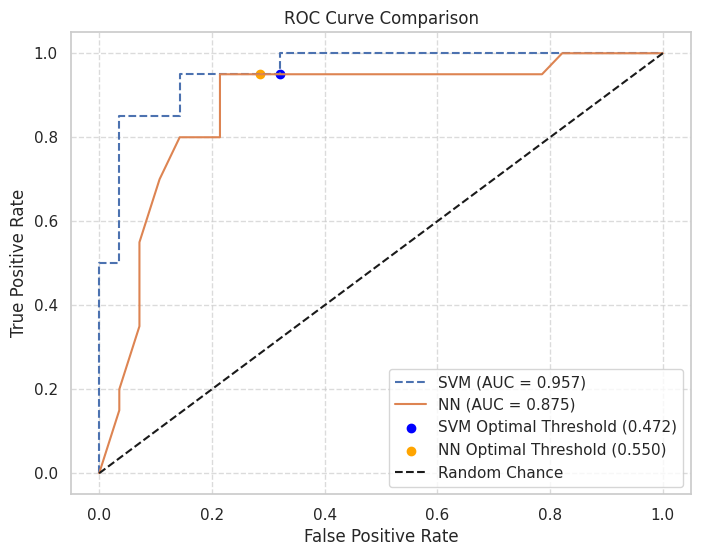

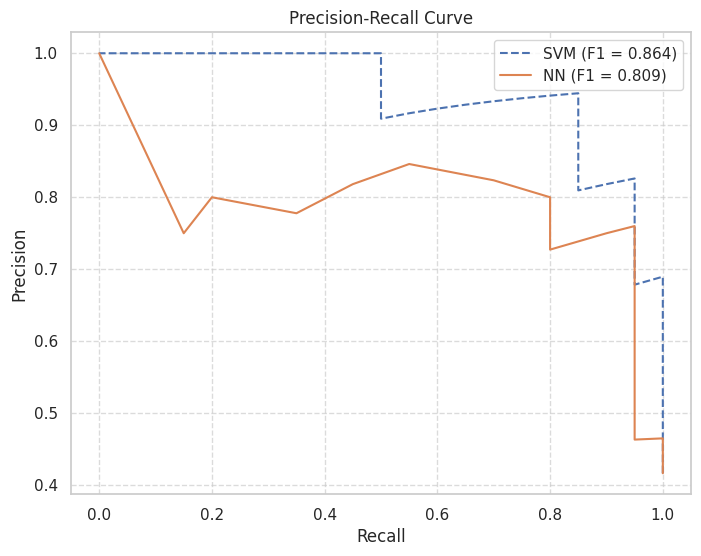

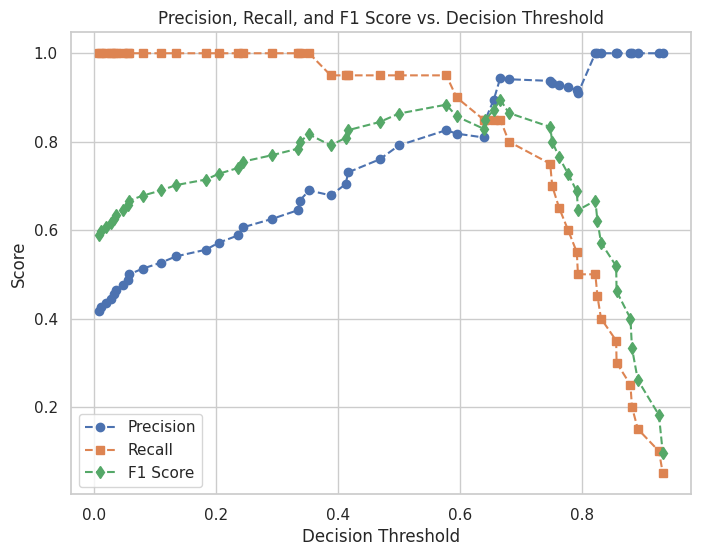

🔹 **SVM Classification Report:**
              precision    recall  f1-score   support

         DME       0.96      0.82      0.88        28
          DR       0.79      0.95      0.86        20

    accuracy                           0.88        48
   macro avg       0.88      0.89      0.87        48
weighted avg       0.89      0.88      0.88        48


🔹 **Neural Network Classification Report:**
              precision    recall  f1-score   support

         DME       0.95      0.71      0.82        28
          DR       0.70      0.95      0.81        20

    accuracy                           0.81        48
   macro avg       0.83      0.83      0.81        48
weighted avg       0.85      0.81      0.81        48



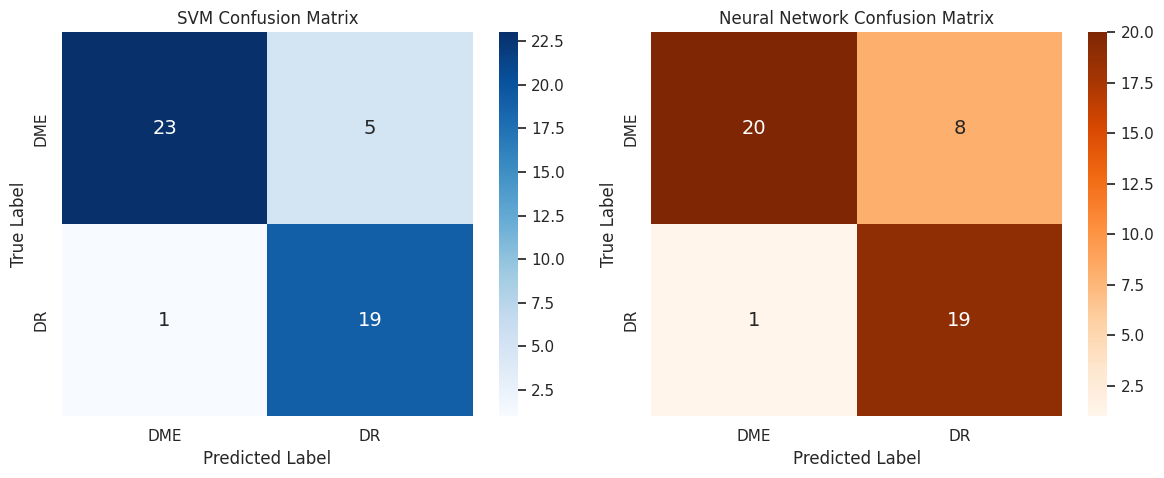

In [ ]:
sns.set_style("whitegrid")
# Get Predicted Probabilities
y_proba_SVM = SVMModel.predict_proba(X_test_SVM)[:, 1]
y_proba_NN = NNModel.predict(X_test_NN).flatten()


# Apply Optimal Thresholds
y_pred_SVM = (y_proba_SVM >= optimal_threshold_SVM).astype(int)
y_pred_NN = (y_proba_NN >= optimal_threshold_NN).astype(int)


print("Predicted Class Distribution:", pd.Series(y_pred_SVM).value_counts())

# Check if probabilities are meaningful
print("Min Prob:", y_proba_SVM.min(), "Max Prob:", y_proba_SVM.max())

# Compute ROC & AUC
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test_SVM, y_proba_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test_NN, y_proba_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

optimal_idx_SVM = np.argmin(np.abs(thresholds_SVM - optimal_threshold_SVM))
optimal_idx_NN = np.argmin(np.abs(thresholds_NN - optimal_threshold_NN))

# Compute Precision-Recall Curves
precision_SVM, recall_SVM, _ = precision_recall_curve(y_test_SVM, y_proba_SVM)
precision_NN, recall_NN, _ = precision_recall_curve(y_test_NN, y_proba_NN)

# Compute Final F1-Scores
f1_SVM = f1_score(y_test_SVM, y_pred_SVM)
f1_NN = f1_score(y_test_NN, y_pred_NN)

# Generate Comparison Table
performance_table = pd.DataFrame({
    "Model": ["SVM (Sigmoid)", "Neural Network"],
    "AUC-ROC": [roc_auc_SVM, roc_auc_NN],
    "Final F1-Score": [f1_SVM, f1_NN],
    "Precomputed Threshold": [optimal_threshold_SVM, optimal_threshold_NN]
})

display(performance_table)
# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_SVM, tpr_SVM, label=f'SVM (AUC = {roc_auc_SVM:.3f})', linestyle='--')
plt.plot(fpr_NN, tpr_NN, label=f'NN (AUC = {roc_auc_NN:.3f})', linestyle='-')
plt.scatter(fpr_SVM[optimal_idx_SVM], tpr_SVM[optimal_idx_SVM], color='blue', marker='o', label=f'SVM Optimal Threshold ({optimal_threshold_SVM:.3f})')
plt.scatter(fpr_NN[optimal_idx_NN], tpr_NN[optimal_idx_NN], color='orange', marker='o', label=f'NN Optimal Threshold ({optimal_threshold_NN:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

save_path = "/content/drive/My Drive/AI Coursework/SVMNN_ROC.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


# Plot Precision-Recall Curves
plt.figure(figsize=(8,6))
plt.plot(recall_SVM, precision_SVM, label=f'SVM (F1 = {f1_SVM:.3f})', linestyle='--')
plt.plot(recall_NN, precision_NN, label=f'NN (F1 = {f1_NN:.3f})', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

save_path = "/content/drive/My Drive/AI Coursework/SVMNN_PRC.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()  # Close figure to prevent overwriting

SVMprecision, SVMrecall, SVMthresholds = precision_recall_curve(y_test_SVM, y_proba_SVM)

# Compute F1 Score for Each Threshold
SVMf1_scores = 2 * (SVMprecision * SVMrecall) / (SVMprecision + SVMrecall)
SVMf1_scores[np.isnan(SVMf1_scores)] = 0  # Replace NaN values with 0

# Plot Precision, Recall, and F1 Score Against Decision Thresholds
plt.figure(figsize=(8, 6))
plt.plot(SVMthresholds, SVMprecision[:-1], label="Precision", linestyle='dashed', marker='o')
plt.plot(SVMthresholds, SVMrecall[:-1], label="Recall", linestyle='dashed', marker='s')
plt.plot(SVMthresholds, SVMf1_scores[:-1], label="F1 Score", linestyle='dashed', marker='d')

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()
plt.close()  # Close figure to prevent overwriting
# Print Classification Reports
print("🔹 **SVM Classification Report:**")
print(classification_report(y_test_SVM, y_pred_SVM, target_names=["DME", "DR"]))
print("\n🔹 **Neural Network Classification Report:**")
print(classification_report(y_test_NN, y_pred_NN, target_names=["DME", "DR"]))

# Compute and Display Confusion Matrices
conf_matrix_SVM = confusion_matrix(y_test_SVM, y_pred_SVM)
conf_matrix_NN = confusion_matrix(y_test_NN, y_pred_NN)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_SVM, annot=True, fmt="d", cmap="Blues", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"], ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(conf_matrix_NN, annot=True, fmt="d", cmap="Oranges", xticklabels=["DME", "DR"], yticklabels=["DME", "DR"], ax=axes[1])
axes[1].set_title("Neural Network Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


## 1-4. Evaluation of Feature Importance

### SHAP - SVM

In [ ]:
# Feature & Label Selection for SVM
XSVM = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))]  # Select relevant features
YSVM = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification


# Reset index to prevent KeyErrors & ensure consistent indexing
XSVM = XSVM.reset_index(drop=True)
YSVM_encoded = pd.Series(LabelEncoder().fit_transform(YSVM)).reset_index(drop=True)
groups = groups.reset_index(drop=True)



# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(XSVM, YSVM_encoded, groups))

# Assign Train-Test Sets for SVM
X_train, X_test = XSVM.iloc[train_idx].copy(), XSVM.iloc[test_idx].copy()
y_train, y_test_NN = YSVM_encoded.iloc[train_idx].copy(), YSVM_encoded.iloc[test_idx].copy()
groups_train, groups_test_SVM = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()

# Scaling
# Identify Continuous and Binary Features
binary_features = [col for col in XSVM.columns if "Biomarker" in col]
continuous_features = ['BCVA', 'CST']

# Fit Scaler on Training Data Only
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])  # Fit & transform train set
X_test[continuous_features] = scaler.transform(X_test[continuous_features])  # Transform test set (NO FITTING!)

column_names = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))].columns  # Get actual column names
X_train = pd.DataFrame(X_train, columns=column_names)
X_test = pd.DataFrame(X_test, columns=column_names)

# Checkpoints for Debugging (SVM)
#print("=== SVM Dataset ===")
#print(f"Train Set Size (SVM): {len(X_train_SVM)}")
#print(f"Test Set Size (SVM): {len(X_test_SVM)}")
#print(f"Class Distribution in Train Set (SVM):\n{pd.Series(y_train_SVM).value_counts(normalize=True)}")
#print(f"Class Distribution in Test Set (SVM):\n{pd.Series(y_test_SVM).value_counts(normalize=True)}")

# Checkpoints for Debugging (NN)
#print("\n=== Neural Network Dataset ===")
#print(f"Train Set Size (NN): {len(X_train_NN)}")
#print(f"Test Set Size (NN): {len(X_test_NN)}")
#print(f"Class Distribution in Train Set (NN):\n{pd.Series(y_train_NN).value_counts(normalize=True)}")
#print(f"Class Distribution in Test Set (NN):\n{pd.Series(y_test_NN).value_counts(normalize=True)}")

# Ensure No Group Leakage for SVM & NN
overlap_SVM = set(groups_train_SVM) & set(groups_test_SVM)


if overlap_SVM:
    print(f"Warning: Groups overlapping between train and test sets (SVM)! {overlap_SVM}")
else:
    print("No group leakage between train and test sets for SVM!")


# Cross-Validation Debugging (DOES NOT affect training)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform Cross-Validation Debugging
def cross_val_debug(X_train, y_train, groups_train, model_name):
    fold = 1
    print(f"\n=== Cross-Validation Debugging for {model_name} ===")

    for train_idx_cv, val_idx_cv in skf.split(X_train, y_train, groups_train):
        # Use RELATIVE indexes from X_train, not the original dataset
        X_train_fold, X_val = X_train.iloc[train_idx_cv], X_train.iloc[val_idx_cv]
        y_train_fold, y_val = y_train.iloc[train_idx_cv], y_train.iloc[val_idx_cv]

        print(f"Fold {fold}:")
        print(f"Train Set: {len(X_train_fold)} samples")
        print(f"Validation Set: {len(X_val)} samples")

        # Check if any test samples are inside CV
        overlap_test = set(groups_test_SVM) & set(groups_train_SVM.iloc[val_idx_cv])
        if overlap_test:
            print(f"Warning: Test set samples found in fold {fold} validation set! {overlap_test}")
        else:
            print("No test samples in validation set.")

        fold += 1

# Run Cross-Validation Debugging for SVM
#cross_val_debug(X_train_SVM, y_train_SVM, groups_train_SVM, "SVM")

# Run Cross-Validation Debugging for NN
#cross_val_debug(X_train_NN, y_train_NN, groups_train_NN, "Neural Network")


✅ No group leakage between train and test sets for SVM!


In [ ]:
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Model class order: {Model.classes_}")

Unique values in y_train: [0 1]
Model class order: [0 1]


SVMModel trained on features: ['Biomarker 1', 'Biomarker 2', 'Biomarker 3', 'Biomarker 4', 'Biomarker 5', 'Biomarker 6', 'Biomarker 7', 'Biomarker 8', 'Biomarker 9', 'Biomarker 10', 'Biomarker 11', 'Biomarker 12', 'Biomarker 13', 'Biomarker 14', 'Biomarker 15', 'Biomarker 16', 'BCVA', 'CST']
Features in X_test before prediction: ['Biomarker 1', 'Biomarker 2', 'Biomarker 3', 'Biomarker 4', 'Biomarker 5', 'Biomarker 6', 'Biomarker 7', 'Biomarker 8', 'Biomarker 9', 'Biomarker 10', 'Biomarker 11', 'Biomarker 12', 'Biomarker 13', 'Biomarker 14', 'Biomarker 15', 'Biomarker 16', 'BCVA', 'CST']
SVMModel.predict_proba(X_test) shape: (48, 2)
First 5 probability predictions:
[[0.94312885 0.05687115]
 [0.708518   0.291482  ]
 [0.79528478 0.20471522]
 [0.6652069  0.3347931 ]
 [0.97133428 0.02866572]]


  0%|          | 0/48 [00:00<?, ?it/s]

Fixed SHAP values type: <class 'list'>
Fixed Number of elements in shap_values list: 1
SHAP values shape before correction: (48, 18, 1)
X_test shape: (48, 18)
Final SHAP values shape after squeeze: (48, 18)
Min SHAP value: -0.367822350920054
Max SHAP value: 0.41921731693258546
Mean SHAP value: 0.013162998735864108
Model classes: [0 1]


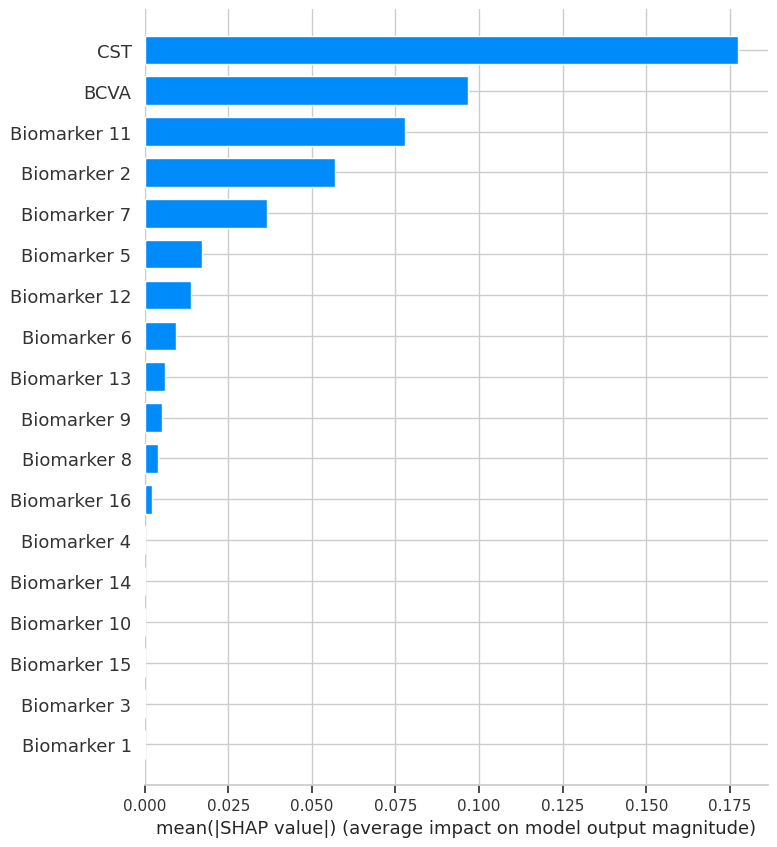

Valid feature indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


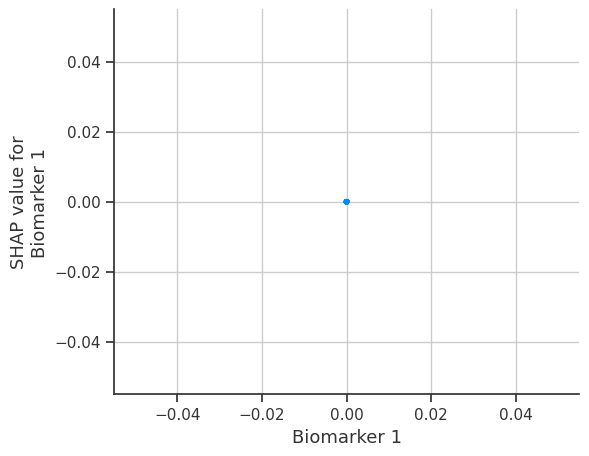

In [ ]:
Model = SVC(kernel = 'sigmoid', probability=True, C= 1.46, gamma= 0.18, class_weight = 'balanced', random_state=42)
Model.fit(X_train, y_train)
print(f"SVMModel trained on features: {list(X_train.columns)}")
print(f"Features in X_test before prediction: {list(X_test.columns)}")

proba_output = SVMModel.predict_proba(X_test)
print(f"SVMModel.predict_proba(X_test) shape: {proba_output.shape}")
print(f"First 5 probability predictions:\n{proba_output[:5]}")



# === Select a Larger Subset of Groups for SHAP Computation ===
unique_groups_train = np.unique(groups_train)
random.seed(42)
selected_groups = random.sample(list(unique_groups_train), k=5)

group_mask = np.isin(groups_train, selected_groups)
X_train_sample = X_train[group_mask][:1000]  # Increased from 500 to 1000 samples

# Convert X_train_sample to DataFrame to match training data
X_train_sample = pd.DataFrame(X_train_sample, columns=X_train.columns)

# Apply SHAP KernelExplainer with Explicit Feature Names
explainer = shap.KernelExplainer(
    lambda x: Model.predict_proba(pd.DataFrame(x, columns=X_train.columns))[:, 1].reshape(-1, 1),
    X_train_sample
)

shap_values = explainer.shap_values(X_test)
# === Fix SHAP Output Format ===
if not isinstance(shap_values, list):
    shap_values = [shap_values]

print(f"Fixed SHAP values type: {type(shap_values)}")
print(f"Fixed Number of elements in shap_values list: {len(shap_values)}")

# === Ensure Correct Shape of SHAP Values ===
print(f"SHAP values shape before correction: {shap_values[0].shape}")
print(f"X_test shape: {X_test.shape}")

# Align row count
shap_values_corrected = shap_values[0][:X_test.shape[0], :]

# Remove extra dimension if present
shap_values_corrected = shap_values_corrected.squeeze()

# Validate shape before proceeding
print(f"Final SHAP values shape after squeeze: {shap_values_corrected.shape}")
assert shap_values_corrected.shape == X_test.shape, "Shape mismatch between SHAP values and X_test!"

# Ensure SHAP Values Are in Correct Format
if isinstance(shap_values_corrected, list):
    shap_values_corrected = shap_values_corrected[0]
shap_values_corrected = shap_values_corrected.squeeze()

# Handle NaN Values
if np.isnan(shap_values_corrected).any():
    print("Warning: SHAP values contain NaNs. Replacing with 0.")
    shap_values_corrected = np.nan_to_num(shap_values_corrected, nan=0.0)

# Debug SHAP Values
print(f"Min SHAP value: {np.nanmin(shap_values_corrected)}")
print(f"Max SHAP value: {np.nanmax(shap_values_corrected)}")
print(f"Mean SHAP value: {np.nanmean(shap_values_corrected)}")
plt.figure()
# SHAP Summary Plot with Correct Feature Names
shap.summary_plot(shap_values_corrected, X_test, feature_names=X_test.columns, show = False)

save_path = "/content/drive/My Drive/AI Coursework/SHAP.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.close()  # Close the figure to prevent duplicate plots

print(f"Model classes: {Model.classes_}")

# === SHAP Bar Plot (Feature Importance) ===
shap.summary_plot(shap_values_corrected, X_test, plot_type="bar")

# === SHAP Dependence Plot (Ensure Feature Index is Valid) ===
valid_feature_indices = list(range(X_test.shape[1]))
print(f"Valid feature indices: {valid_feature_indices}")

# Ensure shape is correct before running dependence plot
if shap_values_corrected.shape == X_test.shape:
    shap.dependence_plot(valid_feature_indices[0], shap_values_corrected, X_test)
else:
    print("Skipping dependence plot due to shape mismatch.")

# === SHAP Force Plot ===
X_test_df = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_corrected[0], X_test_df.iloc[0])


In [ ]:
print(f"Final SHAP values shape: {shap_values_corrected.shape}")
print(f"X_test shape: {X_test.shape}")

Final SHAP values shape: (48, 18, 1)
X_test shape: (48, 18)


# Task 2: Convolutional Neural Network (CNN) for Disease Classification and Data Augmentation




## 2-1. Network Design and Hyperparameter Optimisation

#### Loading Images

In [ ]:



# Define paths
base_path = "/content/drive/My Drive/AI Coursework/images/OLIVES/"
destination_folder = "/content/drive/My Drive/AI Coursework/Cleaned_Images"

for file in os.listdir(destination_folder):
        file_path = os.path.join(destination_folder, file)
        if os.path.isfile(file_path):
            os.remove(file_path)  # Delete each file
print("Cleaned_Images folder cleared.")


# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder, exist_ok=True)

Data['Path'] = Data['Path'].str.strip().str.replace("\\", "/")  # Convert backslashes to forward slashes

def fix_path(path):
    parts = path.split("/")  # Split into directory parts
    if path.startswith("/TREX DME"):  # Ensure full prefix is present
        corrected_path = f"TREX_DME{path}"  # Add missing prefix
    elif path.startswith("/Prime_FULL"):
        corrected_path = f"Prime_FULL{path}"  # Add missing prefix
    else:
        corrected_path = path

    return os.path.join(base_path, corrected_path)  # Construct full path

# Apply path correction
Data['Full_Path'] = Data['Path'].apply(fix_path)

# Print the first few full paths for debugging
print("\nSample of Full Paths:")
print(Data[['Path', 'Full_Path']].head(10).to_string(index=False))

# Copy files in order
for index, row in Data.iterrows():
    source_path = row['Full_Path']

    if os.path.exists(source_path):  # Check if image exists
        file_extension = os.path.splitext(source_path)[1].lower()
        print(file_extension)
        new_filename = f"image{index}{file_extension}"
        destination_path = os.path.join(destination_folder, new_filename)
        shutil.copy(source_path, destination_path)
        print(f"Copied: {source_path} -> {destination_path}")
    else:
        print(f"File not found: {source_path}")

print("\nAll images copied successfully!")

🗑️ Cleaned_Images folder cleared.

🔍 Sample of Full Paths:
                                             Path                                                                                                     Full_Path
    /TREX DME/GILA/0201GOD/V1/OD/TREXJ_000024.tif     /content/drive/My Drive/AI Coursework/images/OLIVES/TREX_DME/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000024.tif
/TREX DME/GILA/0201GOD/V22/OD/TREX_DME_000024.tif /content/drive/My Drive/AI Coursework/images/OLIVES/TREX_DME/TREX DME/GILA/0201GOD/V22/OD/TREX_DME_000024.tif
    /TREX DME/GILA/0203GOS/V1/OS/TREXS_000024.tif     /content/drive/My Drive/AI Coursework/images/OLIVES/TREX_DME/TREX DME/GILA/0203GOS/V1/OS/TREXS_000024.tif
/TREX DME/GILA/0203GOS/V15/OS/TREX_DME_000024.tif /content/drive/My Drive/AI Coursework/images/OLIVES/TREX_DME/TREX DME/GILA/0203GOS/V15/OS/TREX_DME_000024.tif
    /TREX DME/GILA/0204GOS/V1/OS/TREXD_000024.tif     /content/drive/My Drive/AI Coursework/images/OLIVES/TREX_DME/TREX DME/GILA/0204GOS/V1/O

In [ ]:
# Define the path to the cleaned images folder
cleaned_images_folder = "/content/drive/My Drive/AI Coursework/Cleaned_Images"

def count_images(folder_path):
    count = 0
    for _, _, filenames in os.walk(folder_path):
        count += len(filenames)  # Count all files in the folder
    return count

# Get total number of images
total_images = count_images(cleaned_images_folder)

# Print result
print(f"\nTotal number of images in 'Cleaned_Images': {total_images}")


📸 Total number of images in 'Cleaned_Images': 187


### Image Generators (No Augmentation)

In [ ]:
Cleaned_Images = "/content/drive/My Drive/AI Coursework/Cleaned_Images"
ImageData = Data

# Get a list of image filenames from the Cleaned_Images folder
image_filenames = os.listdir(Cleaned_Images)

# Sort filenames numerically (assuming they are named as "image192.tif", "image193.jpg", etc.)
image_filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))  # Extract numeric part and sort

# Ensure all images correspond to the dataframe index
expected_image_names = [f"image{i}{os.path.splitext(image_filenames[0])[1]}" for i in range(len(ImageData))]

# Create a mapping of available images
available_images = {int(''.join(filter(str.isdigit, name))): name for name in image_filenames}

# Replace the `Path` column with the correct image names
missing_images = 0
new_paths = []

for i in range(len(ImageData)):
    if i in available_images:
        new_paths.append(os.path.join(Cleaned_Images, available_images[i]))
    else:
        new_paths.append("MISSING")
        missing_images += 1

ImageData['Path'] = new_paths

# Using .loc for label-based indexing
print(ImageData.loc[187, 'Path'])

# Using .iloc with numerical indices
print(ImageData.iloc[187, ImageData.columns.get_loc('Path')])


ImageData = ImageData[ImageData['Path'] != 'MISSING']


# Group by Eye_ID to prevent data leakage
eye_ids = ImageData['Eye_ID'].unique()

# Stratified sampling using Disease Label
# First split: Train (70%) + Temp (30%)
train_eyes, temp_eyes = train_test_split(
    eye_ids, test_size=0.3, stratify=ImageData.groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Second split: Temp (30%) → Validation (15%) + Test (15%)
val_eyes, test_eyes = train_test_split(
    temp_eyes, test_size=0.5, stratify=ImageData[ImageData["Eye_ID"].isin(temp_eyes)].groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Create train and validation sets
train_ImageData = ImageData[ImageData['Eye_ID'].isin(train_eyes)]
val_ImageData = ImageData[ImageData['Eye_ID'].isin(val_eyes)]
test_ImageData = ImageData[ImageData['Eye_ID'].isin(test_eyes)]


# Print to check correct split
print(f"Train samples: {len(train_ImageData)}")
print(f"Validation samples: {len(val_ImageData)}")
print(f"Test samples: {len(test_ImageData)}")
print(f"Total samples: {len(train_ImageData) + len(val_ImageData) + len(test_ImageData)} (Expected: 187)")

# Print class distribution in train and validation sets
print("Train Set Disease Label Distribution:")
print(train_ImageData['Disease Label'].value_counts(normalize=True))

print("\nValidation Set Disease Label Distribution:")
print(val_ImageData['Disease Label'].value_counts(normalize=True))
print("\nTest Set Disease Label Distribution:")
print(test_ImageData['Disease Label'].value_counts(normalize=True))
# Check original labels
print("Original Unique Labels:", ImageData["Disease Label"].unique())

assert len(set(train_eyes) & set(val_eyes)) == 0, " Train and Validation sets have overlap!"
assert len(set(train_eyes) & set(test_eyes)) == 0, " Train and Test sets have overlap!"
assert len(set(val_eyes) & set(test_eyes)) == 0, " Validation and Test sets have overlap!"
print("No overlap between train, validation, and test sets.")
# Ensure labels are strings before mapping
ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)

# Map labels
class_labels = {label: idx for idx, label in enumerate(ImageData["Disease Label"].unique())}
print("Class Label Mapping:", class_labels)

# Apply mapping and ensure all labels are integers
ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)

# Check for missing labels after mapping
print("Missing Labels After Mapping:", ImageData["Disease Label"].isna().sum())
# Print class label mapping
print(f"Class Label Mapping: {class_labels}")
print(f"Unique Labels in ImageData: {ImageData['Disease Label'].unique()}")

print(f"Unique Eye_IDs in Train: {train_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Validation: {val_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Test: {test_ImageData['Eye_ID'].nunique()}")

MISSING
MISSING
Train samples: 129
Validation samples: 28
Test samples: 30
✅ Total samples: 187 (Expected: 187)
✅ Train Set Disease Label Distribution:
Disease Label
DME    0.604651
DR     0.395349
Name: proportion, dtype: float64

✅ Validation Set Disease Label Distribution:
Disease Label
DME    0.571429
DR     0.428571
Name: proportion, dtype: float64

✅ Test Set Disease Label Distribution:
Disease Label
DME    0.6
DR     0.4
Name: proportion, dtype: float64
Original Unique Labels: ['DME' 'DR']
✅ No overlap between train, validation, and test sets.
Class Label Mapping: {'DME': 0, 'DR': 1}
Missing Labels After Mapping: 0
✅ Class Label Mapping: {'DME': 0, 'DR': 1}
✅ Unique Labels in ImageData: [0 1]
Unique Eye_IDs in Train: 66
Unique Eye_IDs in Validation: 14
Unique Eye_IDs in Test: 15


<ipython-input-5-33e53345f690>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)
<ipython-input-5-33e53345f690>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)


In [ ]:
print(f"Total Unique Eye_IDs: {ImageData['Eye_ID'].nunique()}")
print(f"Train Unique Eye_IDs: {train_ImageData['Eye_ID'].nunique()}")
print(f"Validation Unique Eye_IDs: {val_ImageData['Eye_ID'].nunique()}")
print(f"Test Unique Eye_IDs: {test_ImageData['Eye_ID'].nunique()}")

Total Unique Eye_IDs: 95
Train Unique Eye_IDs: 66
Validation Unique Eye_IDs: 14
Test Unique Eye_IDs: 15


In [ ]:
print("Unique Labels in ImageData:", ImageData["Disease Label"].unique())
print(ImageData.dtypes)  # Ensure column is int

Unique Labels in ImageData: [0 1]
Path             object
Biomarker 1       int64
Biomarker 2       int64
Biomarker 3       int64
Biomarker 4       int64
Biomarker 5       int64
Biomarker 6       int64
Biomarker 7       int64
Biomarker 8       int64
Biomarker 9       int64
Biomarker 10      int64
Biomarker 11      int64
Biomarker 12      int64
Biomarker 13      int64
Biomarker 14      int64
Biomarker 15      int64
Biomarker 16      int64
Eye_ID            int64
BCVA              int64
CST               int64
Disease Label     int64
dtype: object


In [ ]:
class ImageDataGeneratorFromCSV(Sequence):
    def __init__(self, dataframe, batch_size, img_size, datagen, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dataframe = dataframe
        self.batch_size = batch_size  # Dynamically changes per Optuna trial
        self.img_size = img_size
        self.datagen = datagen
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()
    def update_batch_size(self, batch_size):
        """Dynamically update batch size without recreating the generator"""
        self.batch_size = batch_size
    def __len__(self):
        """Ensure it handles batch size updates dynamically"""
        return max(1, int(np.floor(len(self.dataframe) / self.batch_size)))  # Prevents zero batches

    def __getitem__(self, index):
        """Handles batch data dynamically"""
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[indexes]

        if batch_data.empty:  # Prevents "Must provide at least one structure" error
            return np.zeros((self.batch_size, *self.img_size, 3)), np.zeros((self.batch_size,))

        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        """Shuffles data after each epoch to improve generalisation."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        """Loads and processes a batch of images."""
        X = np.empty((self.batch_size, 128, 128, 3))  # Correct shape
        y = np.empty((self.batch_size), dtype=int)  # Label array

        valid_samples = 0  # Track valid samples

        class_labels = {'DME': 0, 'DR': 1}  # Ensure correct mapping

        for i, row in enumerate(batch_data.itertuples()):
            img_path = getattr(row, 'Path')  # Get image path
            label = batch_data.iloc[i]["Disease Label"]

            # Fix: Explicitly convert string labels to integers
            if isinstance(label, str):
                label = class_labels[label]  # Convert 'DME' → 0, 'DR' → 1

            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f" Warning: Missing image at path: {img_path}")  # Debug missing files
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure correct color format
            img = cv2.resize(img, (128, 128))  # Resize image

            # Store only valid samples
            X[valid_samples] = img / 255.0  # Normalise pixel values (0-1)
            y[valid_samples] = label  # Now correctly storing integer labels
            valid_samples += 1  # Increment valid count

        if valid_samples == 0:
            raise ValueError("No valid samples processed! Check label retrieval.")

        return X[:valid_samples], y[:valid_samples]  # Return only valid samples


# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Define ImageDataGenerator for training (NO augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255  # Only normalizing pixel values (0-1)
)

# Define ImageDataGenerator for validation (NO augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalisation

# Create train generator
train_generator = ImageDataGeneratorFromCSV(
    dataframe=train_ImageData,
    batch_size=BATCH_SIZE,
    img_size=(128, 128),
    datagen=train_datagen
)

# Create validation generator (no shuffling)
val_generator = ImageDataGeneratorFromCSV(
    dataframe=val_ImageData,
    batch_size=BATCH_SIZE,
    img_size=(128, 128),
    datagen=val_datagen,
    shuffle = True
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalise

test_generator = ImageDataGeneratorFromCSV(
    dataframe=test_ImageData,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    datagen=test_datagen,
    shuffle=False  # No shuffling for testing
)

print("Data generators are ready for CNN training!")


✅ Data generators are ready for CNN training!


### CNN

In [ ]:
# **Define Paths for Saving Best Model & History**
BEST_MODEL_PATH = "/content/drive/MyDrive/AI Coursework/best_model.keras"
BEST_HISTORY_PATH = "/content/drive/MyDrive/AI Coursework/best_model_history.pkl"

# Function to build CNN model dynamically
def build_model(trial):
    filters_1 = trial.suggest_categorical("filters_1", [32, 64])
    filters_2 = trial.suggest_categorical("filters_2", [32, 64])
    dense_units = trial.suggest_categorical("dense_units", [64, 128])
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-3, log=True)
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])
    use_dropout = trial.suggest_categorical("use_dropout", [True, False])
    use_extra_conv = trial.suggest_categorical("use_extra_conv", [True, False])

    optimizer = {
        "Adam": Adam(learning_rate=learning_rate),
        "SGD": SGD(learning_rate=learning_rate, momentum=0.9),
        "RMSprop": RMSprop(learning_rate=learning_rate)
    }[optimizer_choice]

    model = Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        Conv2D(filters_1, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(filters_2, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate) if use_dropout else tf.keras.layers.Activation('linear'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Optuna objective function
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    train_generator.update_batch_size(batch_size)
    val_generator.update_batch_size(batch_size)

    print(f"Trial {trial.number}: Batch Size = {batch_size}")

    model = build_model(trial)

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=0, min_lr=1e-6)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=[early_stopping, lr_scheduler],
        verbose=0
    )

    val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
    print(f"]Trial {trial.number}: Validation Accuracy = {val_accuracy:.4f}")

    return val_accuracy  # Optuna will maximise accuracy

# Run Optuna optimisation
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Retrieve best trial
best_trial = study.best_trial
print(f"\nBest Hyperparameters: {best_trial.params}")

# Rebuild & retrain best model
best_model = build_model(best_trial)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

# Final evaluation
print("\nEvaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


[I 2025-01-27 00:08:19,441] A new study created in memory with name: no-name-e58a122f-2869-499b-9f25-045474d56bb3


  0%|          | 0/20 [00:00<?, ?it/s]

📊 Trial 0: Batch Size = 16
📝 Trial 0: Validation Accuracy = 0.5625
[I 2025-01-27 00:08:52,639] Trial 0 finished with value: 0.5625 and parameters: {'batch_size': 16, 'filters_1': 32, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.37686636365460796, 'learning_rate': 2.3561242713064687e-05, 'optimizer': 'RMSprop', 'use_batch_norm': True, 'use_dropout': False, 'use_extra_conv': True}. Best is trial 0 with value: 0.5625.
📊 Trial 1: Batch Size = 32
📝 Trial 1: Validation Accuracy = 0.7143
[I 2025-01-27 00:09:23,825] Trial 1 finished with value: 0.7142857313156128 and parameters: {'batch_size': 32, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.4858982448710718, 'learning_rate': 0.0027782605825761187, 'optimizer': 'RMSprop', 'use_batch_norm': False, 'use_dropout': False, 'use_extra_conv': False}. Best is trial 1 with value: 0.7142857313156128.
📊 Trial 2: Batch Size = 16
📝 Trial 2: Validation Accuracy = 0.8125
[I 2025-01-27 00:09:43,547] Trial 2 finished with value: 0.8125

🎯 Best Hyperparameters: {'batch_size': 16, 'filters_1': 32, 'filters_2': 32, 'dense_units': 128, 'dropout': 0.3520206082429643, 'learning_rate': 0.001844002725236884, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': False}


In [ ]:
Best Hyperparameters: {'batch_size': 16, 'filters_1': 64, 'filters_2': 64, 'dense_units': 128, 'dropout': 0.43876573763945864, 'learning_rate': 0.00010541208273468098, 'optimizer': 'Adam', 'use_batch_norm': True, 'use_dropout': False, 'use_extra_conv': True, 'use_l2_reg': False}


In [ ]:
# Manually Set Best Hyperparameters
best_params = {'batch_size': 16, 'filters_1': 32, 'filters_2': 32, 'dense_units': 128, 'dropout': 0.3520206082429643, 'learning_rate': 0.001844002725236884, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': False}
print(f"🎯 Using manually set hyperparameters: {best_params}")
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Forces TensorFlow deterministic operations
# Define Custom F1 Score Metric for TensorFlow
class F1Score(tf.keras.metrics.Metric):
    """Custom macro F1-score metric using TensorFlow."""

    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)  # Convert softmax outputs to class labels
        y_true = tf.cast(y_true, tf.int32)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


# Function to Build CNN Model Using Given Parameters
def build_model_from_params(params):
    """Builds a CNN model using manually provided hyperparameters."""

    optimizer_dict = {
        "Adam": Adam(learning_rate=params["learning_rate"]),
        "SGD": SGD(learning_rate=params["learning_rate"], momentum=0.9),
        "RMSprop": RMSprop(learning_rate=params["learning_rate"])
    }
    optimizer = optimizer_dict[params["optimizer"]]

    # Set fixed initialiser for weight reproducibility
    initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(params["filters_1"], (3,3), activation='relu', padding='same',
                               kernel_initializer=initializer,
                               kernel_regularizer=tf.keras.regularizers.l2(params["l2_lambda"]) if params["use_l2_reg"] else None),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(params["filters_2"], (3,3), activation='relu', padding='same',
                               kernel_initializer=initializer,
                               kernel_regularizer=tf.keras.regularizers.l2(params["l2_lambda"]) if params["use_l2_reg"] else None),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(params["dense_units"], activation='relu', kernel_initializer=initializer),

        tf.keras.layers.Dropout(params["dropout"]) if params["use_dropout"] else tf.keras.layers.Activation('linear'),

        tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=initializer)
    ])

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[F1Score(name="f1_score")])

    return model
best_model = build_model_from_params(best_params)

# Rebuild Model Using Manually Defined Parameters
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0
)

# **Final Model Evaluation**
test_loss, test_f1_score = best_model.evaluate(test_generator, verbose=1)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Macro F1 Score: {test_f1_score:.4f}")




🎯 Using manually set hyperparameters: {'batch_size': 16, 'filters_1': 32, 'filters_2': 32, 'dense_units': 128, 'dropout': 0.3520206082429643, 'learning_rate': 0.001844002725236884, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': False}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - f1_score: 0.7000 - loss: 0.5113
📝 Final Test Loss: 0.5113
📝 Final Test Macro F1 Score: 0.7000


## 2-2. Data Augmentation

Best Hyperparameters: {'batch_size': 32, 'filters_1': 32, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.49952849953193124, 'learning_rate': 2.6062663411749823e-05, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': False, 'use_extra_conv': False, 'use_l2_reg': True, 'l2_lambda': 3.6693758626488305e-05}

Best Hyperparameters: {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.20209168024156943, 'learning_rate': 0.0014878181228062985, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': True, 'l2_lambda': 0.00012880979294811217} 0.9375

0.90625 and parameters: {'batch_size': 16, 'filters_1': 32, 'filters_2': 64, 'dense_units': 64, 'dropout': 0.4884521999555464, 'learning_rate': 0.0009910002171187905, 'optimizer': 'SGD', 'use_batch_norm': False, 'use_dropout': False, 'use_extra_conv': False, 'use_l2_reg': True, 'l2_lambda': 8.867856353927488e-05}. Best is trial 12 with value: 0.90625.

Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to best_model_trial_13.keras

### Image Generators (Augmentation)

In [ ]:
Cleaned_Images = "/content/drive/My Drive/AI Coursework/Cleaned_Images"
ImageData = Data

# Get a list of image filenames from the Cleaned_Images folder
image_filenames = os.listdir(Cleaned_Images)

# Sort filenames numerically (assuming they are named as "image192.tif", "image193.jpg", etc.)
image_filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))  # Extract numeric part and sort

# Ensure all images correspond to the dataframe index
expected_image_names = [f"image{i}{os.path.splitext(image_filenames[0])[1]}" for i in range(len(ImageData))]

# Create a mapping of available images
available_images = {int(''.join(filter(str.isdigit, name))): name for name in image_filenames}

# Replace the `Path` column with the correct image names
missing_images = 0
new_paths = []

for i in range(len(ImageData)):
    if i in available_images:
        new_paths.append(os.path.join(Cleaned_Images, available_images[i]))
    else:
        new_paths.append("MISSING")
        missing_images += 1

ImageData['Path'] = new_paths

# Using .loc for label-based indexing
print(ImageData.loc[187, 'Path'])

# Using .iloc with numerical indices
print(ImageData.iloc[187, ImageData.columns.get_loc('Path')])


ImageData = ImageData[ImageData['Path'] != 'MISSING']


# Group by Eye_ID to prevent data leakage
eye_ids = ImageData['Eye_ID'].unique()

# Stratified sampling using Disease Label
# First split: Train (70%) + Temp (30%)
train_eyes, temp_eyes = train_test_split(
    eye_ids, test_size=0.3, stratify=ImageData.groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Second split: Temp (30%) → Validation (15%) + Test (15%)
val_eyes, test_eyes = train_test_split(
    temp_eyes, test_size=0.5, stratify=ImageData[ImageData["Eye_ID"].isin(temp_eyes)].groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Create train and validation sets
train_ImageData = ImageData[ImageData['Eye_ID'].isin(train_eyes)]
val_ImageData = ImageData[ImageData['Eye_ID'].isin(val_eyes)]
test_ImageData = ImageData[ImageData['Eye_ID'].isin(test_eyes)]


# Print to check correct split
print(f"Train samples: {len(train_ImageData)}")
print(f"Validation samples: {len(val_ImageData)}")
print(f"Test samples: {len(test_ImageData)}")
print(f"Total samples: {len(train_ImageData) + len(val_ImageData) + len(test_ImageData)} (Expected: 187)")

# Print class distribution in train and validation sets
print("Train Set Disease Label Distribution:")
print(train_ImageData['Disease Label'].value_counts(normalize=True))

print("\nValidation Set Disease Label Distribution:")
print(val_ImageData['Disease Label'].value_counts(normalize=True))
print("\nTest Set Disease Label Distribution:")
print(test_ImageData['Disease Label'].value_counts(normalize=True))
# Check original labels
print("Original Unique Labels:", ImageData["Disease Label"].unique())

assert len(set(train_eyes) & set(val_eyes)) == 0, "Train and Validation sets have overlap!"
assert len(set(train_eyes) & set(test_eyes)) == 0, "Train and Test sets have overlap!"
assert len(set(val_eyes) & set(test_eyes)) == 0, "Validation and Test sets have overlap!"
print("No overlap between train, validation, and test sets.")
# Ensure labels are strings before mapping
ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)

# Map labels
class_labels = {label: idx for idx, label in enumerate(ImageData["Disease Label"].unique())}
print("Class Label Mapping:", class_labels)

# Apply mapping and ensure all labels are integers
ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)

# Check for missing labels after mapping
print("Missing Labels After Mapping:", ImageData["Disease Label"].isna().sum())
# Print class label mapping
print(f"Class Label Mapping: {class_labels}")
print(f"Unique Labels in ImageData: {ImageData['Disease Label'].unique()}")

print(f"Unique Eye_IDs in Train: {train_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Validation: {val_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Test: {test_ImageData['Eye_ID'].nunique()}")

MISSING
MISSING
Train samples: 129
Validation samples: 28
Test samples: 30
✅ Total samples: 187 (Expected: 187)
✅ Train Set Disease Label Distribution:
Disease Label
DME    0.604651
DR     0.395349
Name: proportion, dtype: float64

✅ Validation Set Disease Label Distribution:
Disease Label
DME    0.571429
DR     0.428571
Name: proportion, dtype: float64

✅ Test Set Disease Label Distribution:
Disease Label
DME    0.6
DR     0.4
Name: proportion, dtype: float64
Original Unique Labels: ['DME' 'DR']
✅ No overlap between train, validation, and test sets.
Class Label Mapping: {'DME': 0, 'DR': 1}
Missing Labels After Mapping: 0
✅ Class Label Mapping: {'DME': 0, 'DR': 1}
✅ Unique Labels in ImageData: [0 1]
Unique Eye_IDs in Train: 66
Unique Eye_IDs in Validation: 14
Unique Eye_IDs in Test: 15


<ipython-input-96-33e53345f690>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)
<ipython-input-96-33e53345f690>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)


In [ ]:
# **Function to Add Gaussian Noise**
def add_gaussian_noise(image, mean=0, std=0.05):
    noise = np.random.normal(mean, std, image.shape)  # Generate noise
    noisy_image = np.clip(image + noise, 0, 1)  # Apply noise & clip to [0,1] range
    return noisy_image

# **Function to Get Augmented Generator Based on Type**
def get_augmented_generator(aug_type, intensity=None):
    """Returns an ImageDataGenerator with the specified augmentation type and intensity."""

    if aug_type == "Rotation":
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=intensity  # Uses intensity for rotation
        )

    elif aug_type == "Flipping":
        if intensity == "H":
            return ImageDataGenerator(rescale=1./255, horizontal_flip=True)
        elif intensity == "V":
            return ImageDataGenerator(rescale=1./255, vertical_flip=True)
        elif intensity == "H+V":
            return ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

    elif aug_type == "Scaling":
        return ImageDataGenerator(
            rescale=1./255,
            zoom_range=intensity  # Uses intensity for scaling
        )

    elif aug_type == "Noise":
        return ImageDataGenerator(rescale=1./255)  # Now correctly processes noise in `AugmentedImageDataGeneratorFromCSV`

    else:
        raise ValueError(f"Invalid augmentation type: {aug_type}")


# **Modified Data Generator to Handle Augmentations**
class AugmentedImageDataGeneratorFromCSV(ImageDataGeneratorFromCSV):
    def __init__(self, dataframe, batch_size, img_size, augmentation_type, shuffle=True):
        self.augmentation_type = augmentation_type
        datagen = get_augmented_generator(augmentation_type)
        super().__init__(dataframe, batch_size, img_size, datagen, shuffle)

    def __data_generation(self, batch_data):
        """Loads and processes a batch of images with optional augmentation."""
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size), dtype=int)

        valid_samples = 0  # Track valid samples

        for i, row in enumerate(batch_data.itertuples()):
            img_path = getattr(row, 'Path')
            label = batch_data.iloc[i]["Disease Label"]

            # Read image
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠ Warning: Missing image at path: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size[:2])

            # Apply augmentation (except noise)
            img = self.datagen.random_transform(img)
            img = self.datagen.standardize(img)

            # Always Apply Gaussian Noise if aug_type is "Noise"
            if self.augmentation_type == "Noise":
                img = add_gaussian_noise(img)

            X[valid_samples] = img
            y[valid_samples] = label
            valid_samples += 1

        if valid_samples == 0:
            raise ValueError("No valid samples processed! Check label retrieval.")

        return X[:valid_samples], y[:valid_samples]

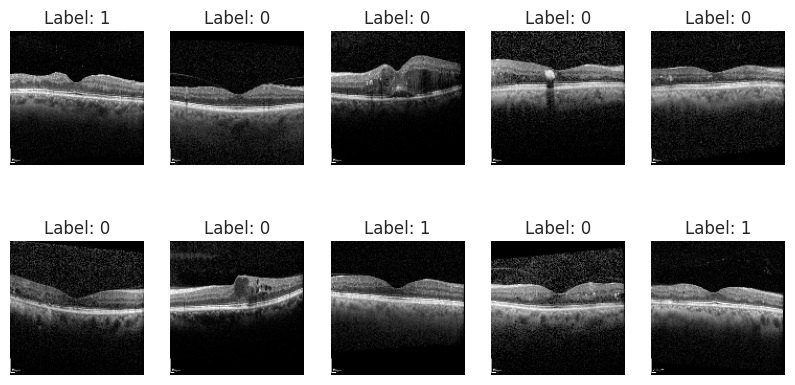

In [ ]:
def visualize_batch(generator, batch_index=0):
    """Displays a batch of images from a given generator."""
    batch_X, batch_y = generator[batch_index]  # Get a batch
    plt.figure(figsize=(10, 5))

    for i in range(min(10, len(batch_X))):  # Show up to 10 images
        plt.subplot(2, 5, i+1)
        plt.imshow(batch_X[i])  # Show image
        plt.title(f"Label: {batch_y[i]}")
        plt.axis("off")

    plt.show()

# Run debugging visualisation
visualize_batch(train_generator)

### CNN

In [ ]:
# Print class distribution for each set
print("Train Set Class Distribution:")
print(train_ImageData["Disease Label"].value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(val_ImageData["Disease Label"].value_counts(normalize=True))

print("\nTest Set Class Distribution:")
print(test_ImageData["Disease Label"].value_counts(normalize=True))


🔍 Train Set Class Distribution:
Disease Label
DME    0.604651
DR     0.395349
Name: proportion, dtype: float64

🔍 Validation Set Class Distribution:
Disease Label
DME    0.571429
DR     0.428571
Name: proportion, dtype: float64

🔍 Test Set Class Distribution:
Disease Label
DME    0.6
DR     0.4
Name: proportion, dtype: float64


In [ ]:
best_hyperparams = {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.60209168024156943, 'learning_rate': 0.0001878181228062985, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': True, 'l2_lambda': 0.00512880979294811217}


🚀 Training Baseline Model (No Augmentation)...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training with Rotation Augmentation (Intensity: 10)...



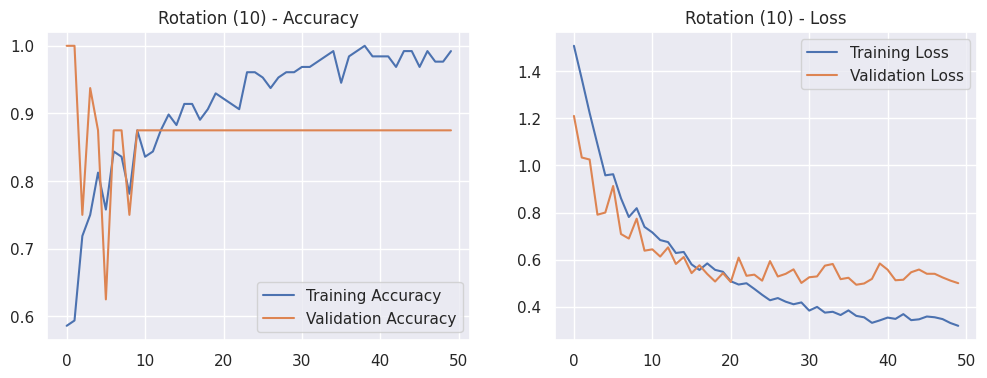


🚀 Training with Rotation Augmentation (Intensity: 20)...



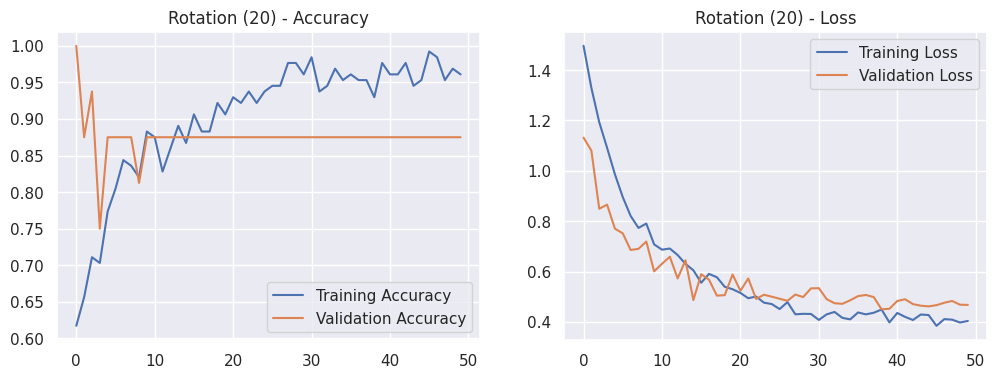


🚀 Training with Rotation Augmentation (Intensity: 30)...



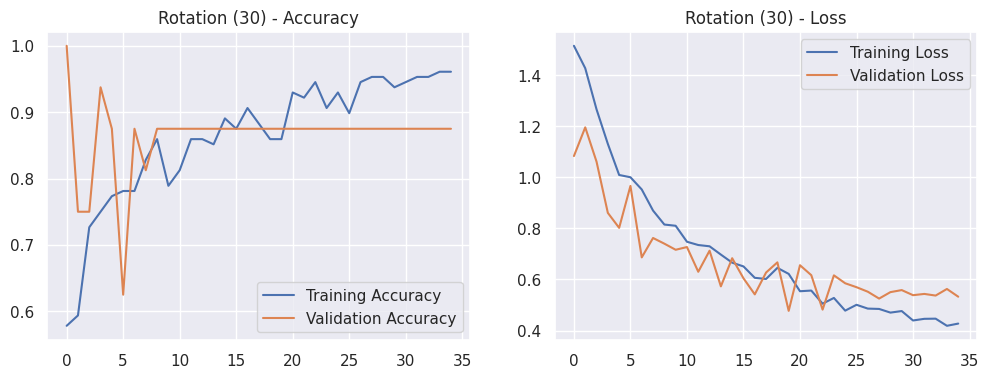


🚀 Training with Flipping Augmentation (Intensity: H)...



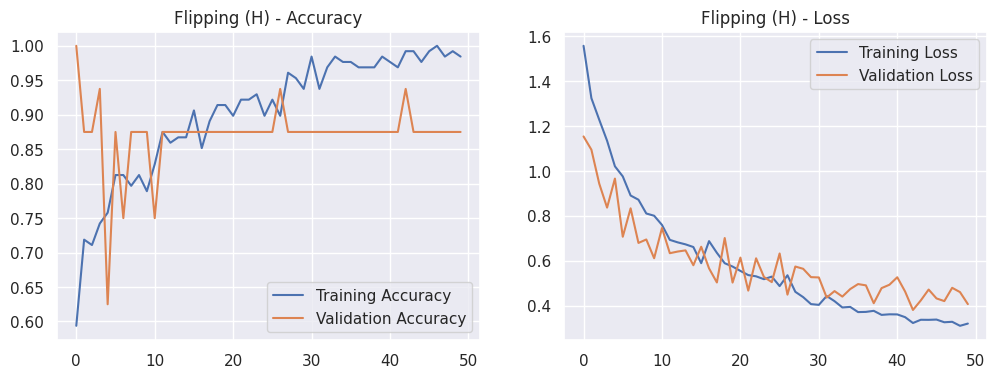


🚀 Training with Flipping Augmentation (Intensity: V)...



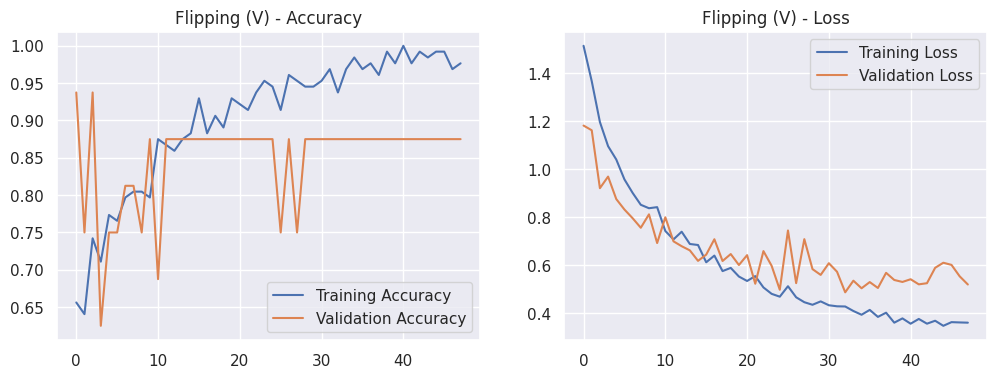


🚀 Training with Flipping Augmentation (Intensity: H+V)...



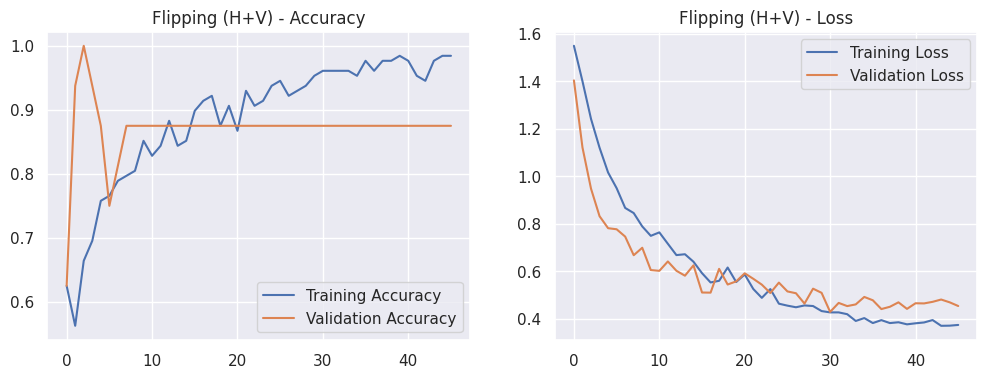


🚀 Training with Scaling Augmentation (Intensity: 0.1)...



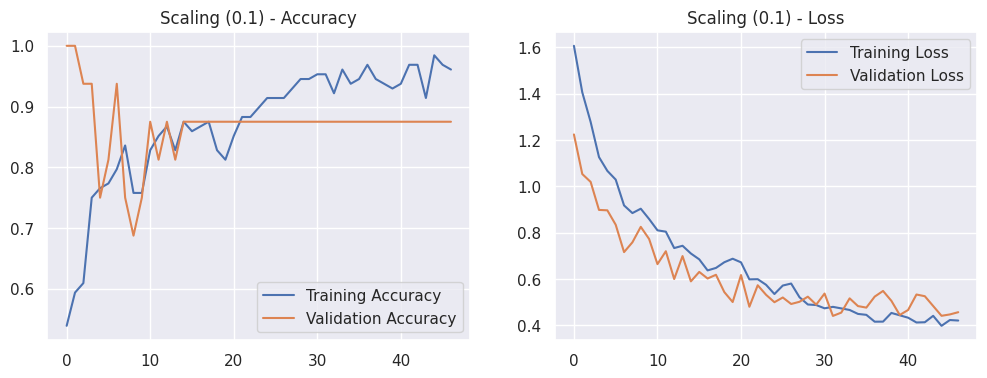


🚀 Training with Scaling Augmentation (Intensity: 0.2)...



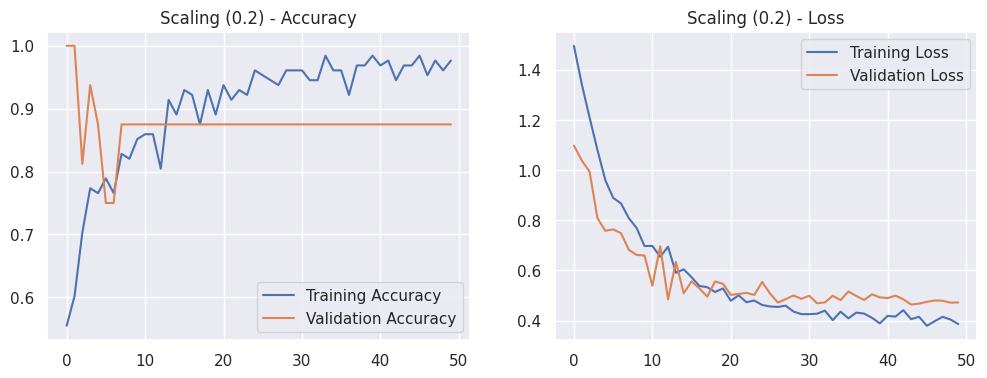


🚀 Training with Scaling Augmentation (Intensity: 0.3)...



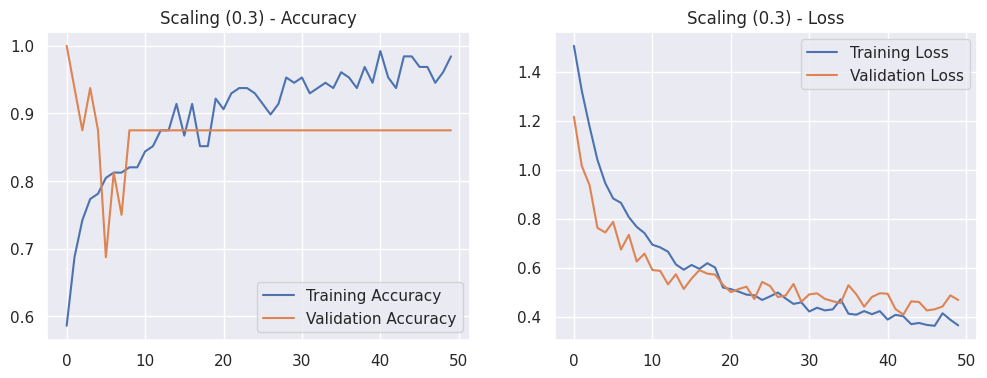


🚀 Training with Noise Augmentation (Intensity: Low)...



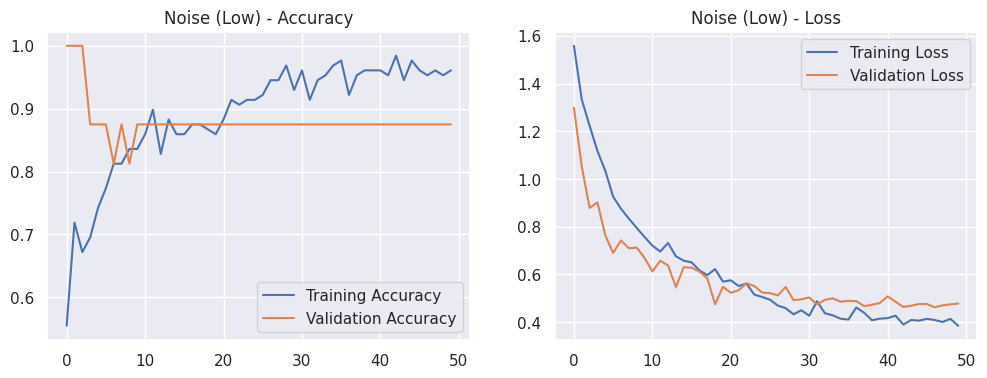


🚀 Training with Noise Augmentation (Intensity: Medium)...



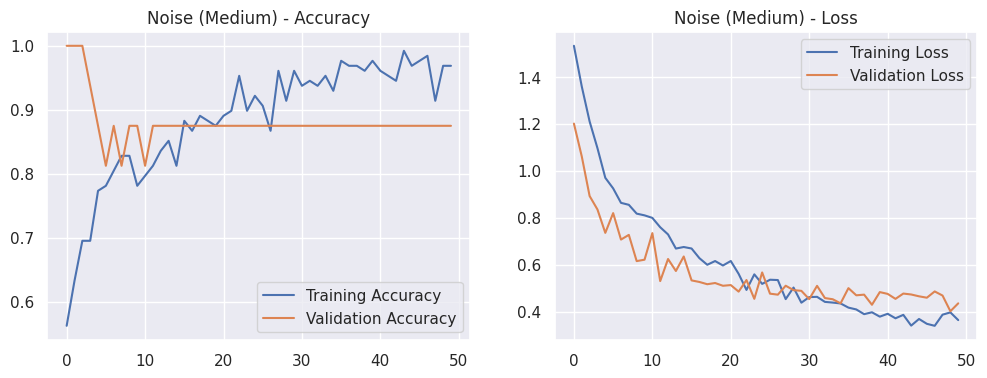


🚀 Training with Noise Augmentation (Intensity: High)...



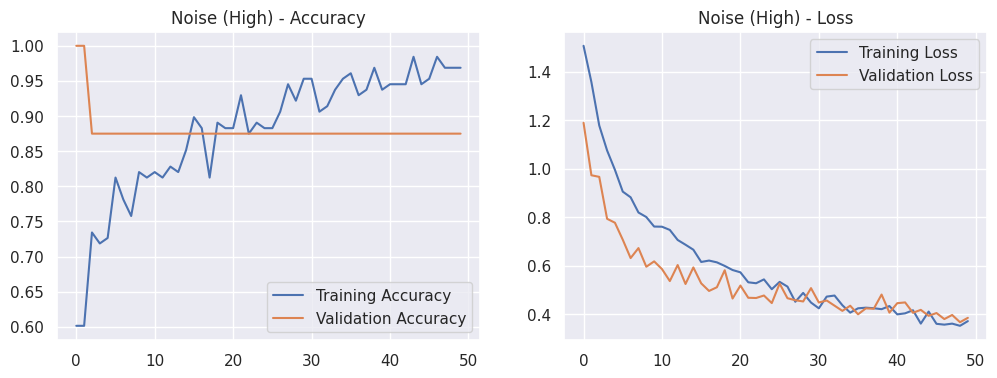


🎯 Performance Comparison:
Baseline (No Augmentation) (None) | Validation Accuracy: 0.8750, Validation Loss: 0.4486 | Test Accuracy: 1.0000, Test Loss: 0.3060
Rotation (10) | Validation Accuracy: 0.8750, Validation Loss: 0.4941 | Test Accuracy: 1.0000, Test Loss: 0.3633
Rotation (20) | Validation Accuracy: 0.8750, Validation Loss: 0.4498 | Test Accuracy: 1.0000, Test Loss: 0.3080
Rotation (30) | Validation Accuracy: 0.8750, Validation Loss: 0.4771 | Test Accuracy: 1.0000, Test Loss: 0.3803
Flipping (H) | Validation Accuracy: 0.9375, Validation Loss: 0.3805 | Test Accuracy: 1.0000, Test Loss: 0.3196
Flipping (V) | Validation Accuracy: 0.8750, Validation Loss: 0.4871 | Test Accuracy: 1.0000, Test Loss: 0.3542
Flipping (H+V) | Validation Accuracy: 0.8750, Validation Loss: 0.4292 | Test Accuracy: 1.0000, Test Loss: 0.3164
Scaling (0.1) | Validation Accuracy: 0.8750, Validation Loss: 0.4413 | Test Accuracy: 1.0000, Test Loss: 0.3306
Scaling (0.2) | Validation Accuracy: 0.8750, Validation Lo

In [ ]:
# **Define augmentation intensities**
augmentation_tests = {
    "Rotation": [10, 20, 30],      # Degrees
    "Flipping": ["H", "V", "H+V"], # Horizontal only, Vertical only, Both
    "Scaling": [0.1, 0.2, 0.3],    # Zoom range (10%, 20%, 30%)
    "Noise": ["Low", "Medium", "High"]  # Noise added separately
}
def build_best_model():
    """Builds a CNN model using the best hyperparameters."""
    model = Sequential([
        Conv2D(best_hyperparams["filters_1"], (3,3), activation='relu', padding='same', input_shape=(128, 128, 3),
               kernel_regularizer=l2(best_hyperparams["l2_lambda"]) if best_hyperparams["use_l2_reg"] else None),
    ])

    if best_hyperparams["use_batch_norm"]:
        model.add(BatchNormalization())

    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(best_hyperparams["filters_2"], (3,3), activation='relu', padding='same',
                     kernel_regularizer=l2(best_hyperparams["l2_lambda"]) if best_hyperparams["use_l2_reg"] else None))

    if best_hyperparams["use_batch_norm"]:
        model.add(BatchNormalization())

    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(best_hyperparams["dense_units"], activation='relu',
                    kernel_regularizer=l2(best_hyperparams["l2_lambda"]) if best_hyperparams["use_l2_reg"] else None))

    if best_hyperparams["use_dropout"]:
        model.add(Dropout(best_hyperparams["dropout"]))

    model.add(Dense(2, activation='softmax'))  # Assuming binary classification

    optimizer = Adam(learning_rate=best_hyperparams["learning_rate"])

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

results = []

# **Train Baseline Model (No Augmentation)**
print(f"\nTraining Baseline Model (No Augmentation)...\n")

# Define standard ImageDataGenerator (No augmentation)
baseline_datagen = ImageDataGenerator(rescale=1./255)

train_baseline_generator = ImageDataGeneratorFromCSV(
    dataframe=train_ImageData,
    batch_size=best_hyperparams["batch_size"],
    img_size=(128, 128),
    datagen=baseline_datagen,
    shuffle=True
)

# Create validation generator (no augmentation)
val_generator = ImageDataGeneratorFromCSV(
    dataframe=val_ImageData,
    batch_size=best_hyperparams["batch_size"],
    img_size=(128, 128),
    datagen=baseline_datagen,  # No augmentation
    shuffle=False
)

# Create test generator
test_generator = ImageDataGeneratorFromCSV(
    dataframe=test_ImageData,
    batch_size=best_hyperparams["batch_size"],
    img_size=(128, 128),
    datagen=baseline_datagen,  # No augmentation
    shuffle=False
)

# **Train and Evaluate Models**
def train_and_evaluate(model_name, train_generator):
    """Train a model and evaluate on validation & test sets."""
    model = build_best_model()

    early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=5, verbose=0, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(f"{model_name}.keras", save_best_only=True, monitor="val_loss", verbose=0)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        verbose=0,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

    # Load best model after training
    model = tf.keras.models.load_model(f"{model_name}.keras")

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    return history, val_accuracy, val_loss, test_accuracy, test_loss

# **Train Baseline Model**
baseline_history, baseline_val_acc, baseline_val_loss, baseline_test_acc, baseline_test_loss = train_and_evaluate("best_baseline_model", train_baseline_generator)

results.append(("Baseline (No Augmentation)", "None", baseline_val_acc, baseline_val_loss, baseline_test_acc, baseline_test_loss))

# **Train Models with Augmentations**
for aug_type, intensities in augmentation_tests.items():
    for intensity in intensities:
        print(f"\nTraining with {aug_type} Augmentation (Intensity: {intensity})...\n")

        # Get augmented training data generator
        train_augmented_datagen = get_augmented_generator(aug_type, intensity)
        train_augmented_generator = ImageDataGeneratorFromCSV(
            dataframe=train_ImageData,
            batch_size=best_hyperparams["batch_size"],
            img_size=(128, 128),
            datagen=train_augmented_datagen,
            shuffle=True
        )

        # Train model
        history, val_acc, val_loss, test_acc, test_loss = train_and_evaluate(f"best_model_{aug_type}_{intensity}", train_augmented_generator)

        # Store results
        results.append((aug_type, intensity, val_acc, val_loss, test_acc, test_loss))

        # Plot learning curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], label="Training Accuracy")
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
        plt.title(f"{aug_type} ({intensity}) - Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{aug_type} ({intensity}) - Loss")
        plt.legend()

        plt.show()

# **Compare Results**
print("\nPerformance Comparison:")
for aug_type, intensity, val_acc, val_loss, test_acc, test_loss in results:
    print(f"{aug_type} ({intensity}) | Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f} | Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


## 2-3. Performance Analysis and Metrics

In [ ]:
Cleaned_Images = "/content/drive/My Drive/AI Coursework/Cleaned_Images"
ImageData = Data

# Get a list of image filenames from the Cleaned_Images folder
image_filenames = os.listdir(Cleaned_Images)

# Sort filenames numerically (assuming they are named as "image192.tif", "image193.jpg", etc.)
image_filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))  # Extract numeric part and sort

# Ensure all images correspond to the dataframe index
expected_image_names = [f"image{i}{os.path.splitext(image_filenames[0])[1]}" for i in range(len(ImageData))]

# Create a mapping of available images
available_images = {int(''.join(filter(str.isdigit, name))): name for name in image_filenames}

# Replace the `Path` column with the correct image names
missing_images = 0
new_paths = []

for i in range(len(ImageData)):
    if i in available_images:
        new_paths.append(os.path.join(Cleaned_Images, available_images[i]))
    else:
        new_paths.append("MISSING")
        missing_images += 1

ImageData['Path'] = new_paths

# Using .loc for label-based indexing
print(ImageData.loc[187, 'Path'])

# Using .iloc with numerical indices
print(ImageData.iloc[187, ImageData.columns.get_loc('Path')])


ImageData = ImageData[ImageData['Path'] != 'MISSING']


# Group by Eye_ID to prevent data leakage
eye_ids = ImageData['Eye_ID'].unique()

# First split: Train (70%) + Temp (30%)
train_eyes, temp_eyes = train_test_split(
    eye_ids, test_size=0.3, stratify=ImageData.groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Second split: Temp (30%) → Validation (15%) + Test (15%)
val_eyes, test_eyes = train_test_split(
    temp_eyes, test_size=0.5, stratify=ImageData[ImageData["Eye_ID"].isin(temp_eyes)].groupby('Eye_ID')['Disease Label'].first(), random_state=42
)

# Create train and validation sets
train_ImageData = ImageData[ImageData['Eye_ID'].isin(train_eyes)]
val_ImageData = ImageData[ImageData['Eye_ID'].isin(val_eyes)]
test_ImageData = ImageData[ImageData['Eye_ID'].isin(test_eyes)]


# Print to check correct split
print(f"Train samples: {len(train_ImageData)}")
print(f"Validation samples: {len(val_ImageData)}")
print(f"Test samples: {len(test_ImageData)}")
print(f"Total samples: {len(train_ImageData) + len(val_ImageData) + len(test_ImageData)} (Expected: 187)")

# Print class distribution in train and validation sets
print("Train Set Disease Label Distribution:")
print(train_ImageData['Disease Label'].value_counts(normalize=True))

print("\nValidation Set Disease Label Distribution:")
print(val_ImageData['Disease Label'].value_counts(normalize=True))
print("\nTest Set Disease Label Distribution:")
print(test_ImageData['Disease Label'].value_counts(normalize=True))
# Check original labels
print("Original Unique Labels:", ImageData["Disease Label"].unique())

assert len(set(train_eyes) & set(val_eyes)) == 0, "Train and Validation sets have overlap!"
assert len(set(train_eyes) & set(test_eyes)) == 0, "Train and Test sets have overlap!"
assert len(set(val_eyes) & set(test_eyes)) == 0, "Validation and Test sets have overlap!"
print("No overlap between train, validation, and test sets.")
# Ensure labels are strings before mapping
ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)

# Map labels
class_labels = {label: idx for idx, label in enumerate(ImageData["Disease Label"].unique())}
print("Class Label Mapping:", class_labels)

# Apply mapping and ensure all labels are integers
ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)

# Check for missing labels after mapping
print("Missing Labels After Mapping:", ImageData["Disease Label"].isna().sum())
# Print class label mapping
print(f"Class Label Mapping: {class_labels}")
print(f"Unique Labels in ImageData: {ImageData['Disease Label'].unique()}")

print(f"Unique Eye_IDs in Train: {train_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Validation: {val_ImageData['Eye_ID'].nunique()}")
print(f"Unique Eye_IDs in Test: {test_ImageData['Eye_ID'].nunique()}")
# ----------------------------------------------
#**Augmentation Functions**
# ----------------------------------------------
def add_gaussian_noise(image, mean=0, std=0.1):
    """Applies Gaussian noise with a specified standard deviation."""
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 1)

def get_augmented_generator():
    """Returns an ImageDataGenerator with rotation, flipping, and rescaling."""
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  #Always apply ±10 degree rotation
        horizontal_flip=True  #Always apply horizontal flip
    )

#**Custom Augmented Data Generator**
class AugmentedImageDataGeneratorFromCSV(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, shuffle=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        if shuffle:
            np.random.shuffle(self.indices)

        #Always apply rotation, flipping, and normalisation
        self.datagen = get_augmented_generator()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]

        X = np.empty((len(batch_data), *self.img_size, 3))
        y = np.empty((len(batch_data)), dtype=int)

        for i, row in enumerate(batch_data.itertuples()):
            img = cv2.imread(row.Path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size[:2])

            #Apply standard augmentations (Rotation + Flip)
            img = self.datagen.random_transform(img)
            img = self.datagen.standardize(img)

            #Apply Gaussian Noise (Always)
            img = add_gaussian_noise(img)

            X[i] = img
            y[i] = row._asdict()["Disease Label"]

        return X, y



#Baseline Data Generator (No Augmentation)
baseline_datagen = ImageDataGenerator(rescale=1./255)

train_baseline_generator = baseline_datagen.flow_from_dataframe(
    dataframe=train_ImageData,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse"
)

#Augmented Training Data Generator (Fixed)
train_augmented_generator = AugmentedImageDataGeneratorFromCSV(
    dataframe=train_ImageData,
    batch_size=32,
    img_size=(128, 128),
    shuffle=True
)

#Validation Generator (No Augmentation)
val_generator = baseline_datagen.flow_from_dataframe(
    dataframe=val_ImageData,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Validation set should NOT be shuffled
)

#Test Generator (No Augmentation)
test_generator = baseline_datagen.flow_from_dataframe(
    dataframe=test_ImageData,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Test set should NOT be shuffled
)


print("\nData Generators Created Successfully!")


MISSING
MISSING
Train samples: 129
Validation samples: 28
Test samples: 30
✅ Total samples: 187 (Expected: 187)
✅ Train Set Disease Label Distribution:
Disease Label
DME    0.604651
DR     0.395349
Name: proportion, dtype: float64

✅ Validation Set Disease Label Distribution:
Disease Label
DME    0.571429
DR     0.428571
Name: proportion, dtype: float64

✅ Test Set Disease Label Distribution:
Disease Label
DME    0.6
DR     0.4
Name: proportion, dtype: float64
Original Unique Labels: ['DME' 'DR']
✅ No overlap between train, validation, and test sets.
Class Label Mapping: {'DME': 0, 'DR': 1}
Missing Labels After Mapping: 0
✅ Class Label Mapping: {'DME': 0, 'DR': 1}
✅ Unique Labels in ImageData: [0 1]
Unique Eye_IDs in Train: 66
Unique Eye_IDs in Validation: 14
Unique Eye_IDs in Test: 15
Found 129 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.

🚀 Data Generators Create

<ipython-input-13-0e9e2fe95998>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].astype(str)
<ipython-input-13-0e9e2fe95998>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImageData["Disease Label"] = ImageData["Disease Label"].map(class_labels).astype(int)


Found 129 validated image filenames belonging to 2 classes.
Found 129 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.6208 - loss: 1.2938 - val_accuracy: 0.7857 - val_loss: 0.6209
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6268 - loss: 0.6647 - val_accuracy: 0.5714 - val_loss: 0.6729
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5038 - loss: 0.7943 - val_accuracy: 0.5714 - val_loss: 0.7007
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6485 - loss: 0.6995 - val_accuracy: 0.6071 - val_loss: 0.7020
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.7766 - loss: 0.6884 - val_accuracy: 0.6429 - val_loss: 0.6661
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6898 - loss: 0.6227 - val_accuracy: 0.5714 - val_loss: 0.7922
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6640 - loss: 0.6070 - val_accuracy: 0.6071 - val_loss: 0.5815
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8310 - loss: 0.5131 - val_accuracy: 0.6071 - val_loss: 0.7729
Epoch 9/50

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step - accuracy: 0.5586 - loss: 1.1195 - val_accuracy: 0.5714 - val_loss: 0.7067
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7195 - loss: 0.6210 - val_accuracy: 0.5714 - val_loss: 0.6874
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6056 - loss: 0.6910 - val_accuracy: 0.5714 - val_loss: 0.7064
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6595 - loss: 0.6798 - val_accuracy: 0.5714 - val_loss: 0.8689
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5938 - loss: 0.7107 - val_accuracy: 0.4286 - val_loss: 0.8603
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4787 - loss: 0.8087 - val_accuracy: 0.5714 - val_loss: 0.7032
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5337 - loss: 0.7045 - val_accuracy: 0.6071 - val_loss: 0.6975
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6586 - loss: 0.6822 - val_accuracy: 0.5714 - val_loss: 0.6893
Epoch 9/5

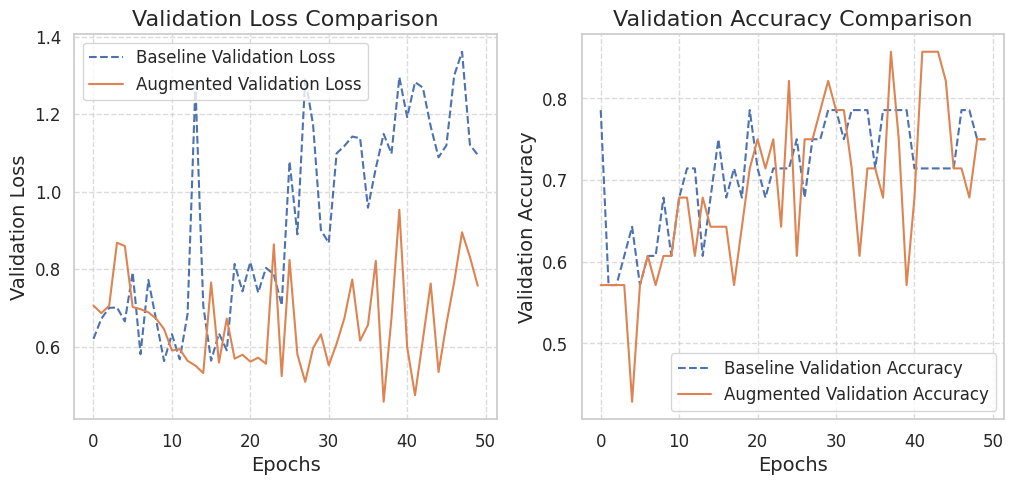

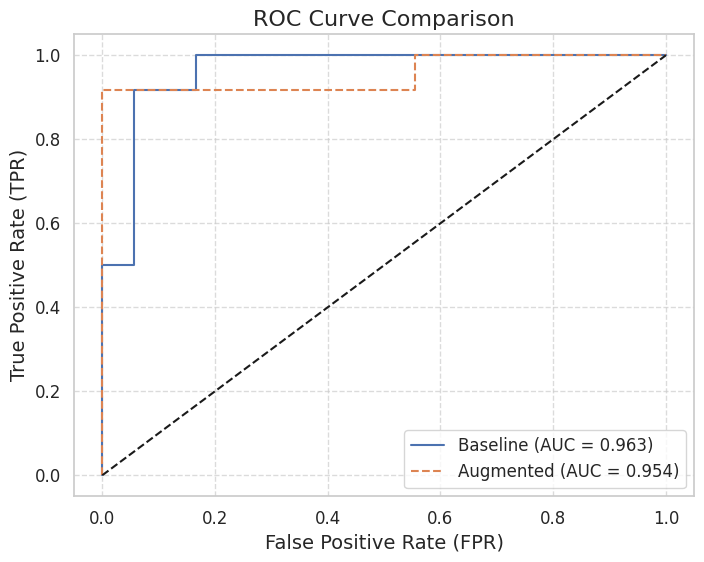

In [ ]:
#Manually set hyperparameters
hyper_params = {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.20209168024156943, 'learning_rate': 0.0014878181228062985, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': True, 'l2_lambda': 0.00012880979294811217}

#Function to build model using the best hyperparameters
def build_best_model():
    """Builds a CNN model using manually defined hyperparameters."""
    model = Sequential([
        Conv2D(hyper_params["filters_1"], (3,3), activation='relu', padding='same', input_shape=(128, 128, 3),
               kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None),
    ])

    if hyper_params["use_batch_norm"]:
        model.add(BatchNormalization())

    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(hyper_params["filters_2"], (3,3), activation='relu', padding='same',
                     kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None))

    if hyper_params["use_batch_norm"]:
        model.add(BatchNormalization())

    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(hyper_params["dense_units"], activation='relu',
                    kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None))

    if hyper_params["use_dropout"]:
        model.add(Dropout(hyper_params["dropout"]))

    model.add(Dense(2, activation='softmax'))  # Assuming binary classification

    optimizer = Adam(learning_rate=hyper_params["learning_rate"])

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Function to compute evaluation metrics
def evaluate_model(model, generator):
    """Evaluates a trained model using Accuracy, Precision, Recall, F1, and ROC-AUC"""
    y_true, y_pred, y_probs = [], [], []

    # Iterate through batches
    for batch_x, batch_y in generator:
        probs = model.predict(batch_x, verbose=0)  # Get softmax probabilities
        preds = probs.argmax(axis=1)  # Convert to class labels

        y_true.extend(batch_y)
        y_pred.extend(preds)
        y_probs.extend(probs[:, 1])  # Store probability of class 1 (DME)

        if len(y_true) >= generator.n:  # Stop iteration when dataset is covered
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Compute ROC Curve and AUC (Binary Only)
    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        roc_curve_data = (fpr, tpr)  # Store ROC curve
    else:
        roc_auc = roc_auc_score(y_true, probs, multi_class="ovr")
        roc_curve_data = None  # Multiclass ROC not plotted here

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1 Score": f1_score(y_true, y_pred, average='macro'),
        "ROC AUC": roc_auc,
        "ROC Curve": roc_curve_data  # Store for plotting
    }

# Prepare Data Generators
baseline_datagen = ImageDataGenerator(rescale=1./255)
augmented_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, zoom_range=0.2)

train_baseline_generator = baseline_datagen.flow_from_dataframe(
    dataframe=train_ImageData,
    directory=None,  # Paths are absolute or stored in 'Path' column
    x_col="Path",    # Column containing image paths
    y_col="Disease Label",  # Column containing labels
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for integer labels
)

train_augmented_generator = augmented_datagen.flow_from_dataframe(
    dataframe=train_ImageData,
    directory=None,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse'
)

# Validation Generator (No Augmentation)
val_generator = baseline_datagen.flow_from_dataframe(
    dataframe=val_ImageData,
    directory=None,  # Paths are absolute or stored in 'Path' column
    x_col="Path",    # Column containing image paths
    y_col="Disease Label",  # Column containing labels
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels
    shuffle=False  # No need to shuffle validation set
)

# Test Generator (No Augmentation)
test_generator = baseline_datagen.flow_from_dataframe(
    dataframe=test_ImageData,
    directory=None,  # Paths are absolute or stored in 'Path' column
    x_col="Path",
    y_col="Disease Label",
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # No need to shuffle test set
)



# Train Non-Augmented Model
baseline_model = build_best_model()
history_baseline = baseline_model.fit(train_baseline_generator, validation_data=val_generator, epochs=50,  verbose=1)
baseline_metrics = evaluate_model(baseline_model, test_generator)

# Train Augmented Model
augmented_model = build_best_model()
history_augmented = augmented_model.fit(train_augmented_generator, validation_data=val_generator, epochs=50, verbose=1)
augmented_metrics = evaluate_model(augmented_model, test_generator)

# Compare Results
df_results = pd.DataFrame([baseline_metrics, augmented_metrics], index=['Baseline', 'Augmented'])
print(df_results)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# Plot Validation Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Validation Accuracy', linestyle='--')
plt.plot(history_augmented.history['val_accuracy'], label='Augmented Validation Accuracy', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.grid(True, linestyle="--", alpha=0.7)
# Plot Validation Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['val_loss'], label='Baseline Validation Loss', linestyle='--')
plt.plot(history_augmented.history['val_loss'], label='Augmented Validation Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("/content/drive/My Drive/AI Coursework/LearningCurvesT2.pdf", dpi=300, bbox_inches='tight')  # High-quality PNG

plt.show()

plt.figure(figsize=(8, 6))

# Baseline Model
if baseline_metrics["ROC Curve"] is not None:
    fpr_base, tpr_base = baseline_metrics["ROC Curve"]
    plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {baseline_metrics['ROC AUC']:.3f})")

# Augmented Model
if augmented_metrics["ROC Curve"] is not None:
    fpr_aug, tpr_aug = augmented_metrics["ROC Curve"]
    plt.plot(fpr_aug, tpr_aug, label=f"Augmented (AUC = {augmented_metrics['ROC AUC']:.3f})", linestyle="--")

# Plot Settings
plt.plot([0, 1], [0, 1], "k--")  # Diagonal (Random Classifier)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.savefig("/content/drive/My Drive/AI Coursework/ROCT2.pdf", dpi=300, bbox_inches='tight')  # High-quality PNG

plt.show()

## 2-4. Fine-Tuning with Pre-trained Model


In [ ]:
print("Unique Labels in ImageData Before Generator:", ImageData["Disease Label"].unique())
print(ImageData.dtypes)
for _, labels in train_generator:
    print(f"Sample labels from generator: {labels[:19]}")
    break

Unique Labels in ImageData Before Generator: [0 1]
Path             object
Biomarker 1       int64
Biomarker 2       int64
Biomarker 3       int64
Biomarker 4       int64
Biomarker 5       int64
Biomarker 6       int64
Biomarker 7       int64
Biomarker 8       int64
Biomarker 9       int64
Biomarker 10      int64
Biomarker 11      int64
Biomarker 12      int64
Biomarker 13      int64
Biomarker 14      int64
Biomarker 15      int64
Biomarker 16      int64
Eye_ID            int64
BCVA              int64
CST               int64
Disease Label     int64
dtype: object
Sample labels from generator: [1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1]


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4688 - loss: 0.7665 - val_accuracy: 0.5714 - val_loss: 0.7363
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.6302 - loss: 0.6937 - val_accuracy: 0.5714 - val_loss: 0.6516
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.6146 - loss: 0.6444 - val_accuracy: 0.7500 - val_loss: 0.6149
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.7188 - loss: 0.5857 - val_accuracy: 0.6071 - val_loss: 0.5734
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.7344 - loss: 0.5388 - val_accuracy: 0.5714 - val_loss: 0.5909
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.7292 - loss: 0.4822 - val_accuracy: 0.7857 - val_loss: 0.5046
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.8385 - loss: 0.4287 - val_accuracy: 0.7500 - val_loss: 0.4815
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.8125 - loss: 0.3954 - val_accuracy: 0.7857 - val_loss: 0.

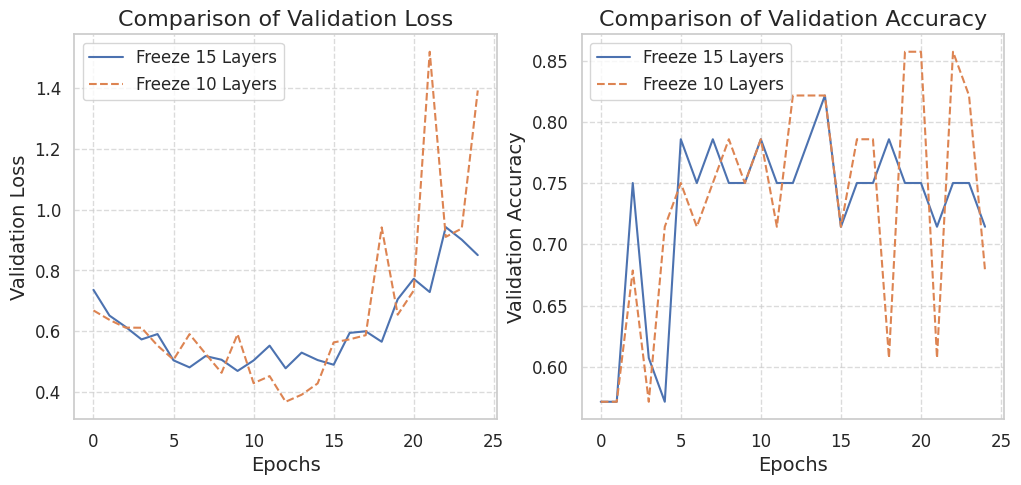

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


,Accuracy,Precision,Recall,F1 Score
Freeze 15 Layers,0.714286,0.666667,0.666667,0.666667
Freeze 10 Layers,0.678571,0.714286,0.416667,0.526316


In [ ]:
def build_vgg16_model(freeze_layers):
    """Loads VGG16, freezes layers, and adds a custom classification head."""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze layers up to 'freeze_layers'
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Add new classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)  # Binary classification (DME vs DR)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train & Evaluate Model with 15 Frozen Layers
model_15 = build_vgg16_model(freeze_layers=15)
history_15 = model_15.fit(train_generator, epochs= 25, validation_data=val_generator)

# Train & Evaluate Model with 10 Frozen Layers
model_10 = build_vgg16_model(freeze_layers=10)
history_10 = model_10.fit(train_generator, epochs= 25, validation_data=val_generator)

# Plot Validation Accuracy & Loss Comparison
def plot_learning_curve(history_15, history_10):
    plt.figure(figsize=(12, 5))

    # Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_15.history['val_accuracy'], label='Freeze 15 Layers')
    plt.plot(history_10.history['val_accuracy'], label='Freeze 10 Layers', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Comparison of Validation Accuracy')
    plt.grid(True, linestyle="--", alpha=0.7)
    # Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_15.history['val_loss'], label='Freeze 15 Layers')
    plt.plot(history_10.history['val_loss'], label='Freeze 10 Layers', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.title('Comparison of Validation Loss')
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.savefig("/content/drive/My Drive/AI Coursework/VGG16Comp.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_curve(history_15, history_10)

# Evaluate Models Using Classification Metrics
y_true = val_generator.classes  # True labels

# Predict on Validation Set
y_pred_15 = np.argmax(model_15.predict(val_generator), axis=1)
y_pred_10 = np.argmax(model_10.predict(val_generator), axis=1)

# Compute Metrics
metrics_15 = {
    'Accuracy': accuracy_score(y_true, y_pred_15),
    'Precision': precision_score(y_true, y_pred_15, average='binary'),
    'Recall': recall_score(y_true, y_pred_15, average='binary'),
    'F1 Score': f1_score(y_true, y_pred_15, average='binary')
}

metrics_10 = {
    'Accuracy': accuracy_score(y_true, y_pred_10),
    'Precision': precision_score(y_true, y_pred_10, average='binary'),
    'Recall': recall_score(y_true, y_pred_10, average='binary'),
    'F1 Score': f1_score(y_true, y_pred_10, average='binary')
}

# Create Table for Comparison
comparison_df = pd.DataFrame([metrics_15, metrics_10], index=['Freeze 15 Layers', 'Freeze 10 Layers'])

# Display Table
from IPython.display import display
display(comparison_df)

# Task 3: Integrating Clinical Labels, Biomarkers, and OCT Images

## 3-1. Feature Fusion with CNN


In [ ]:
hyper_params = {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.20209168024156943, 'learning_rate': 0.0014878181228062985, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': True, 'l2_lambda': 0.00012880979294811217}

In [ ]:
ImportantFeatures = Data[['Biomarker 2', 'Biomarker 7', 'Biomarker 11', 'BCVA', 'CST']]
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification

# Reset index to prevent KeyErrors & ensure consistent indexing
X = ImportantFeatures.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)

# Perform a Single Train-Test Split with Stratification & Grouping
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))

# Apply Stratified Split to Images
image_paths = Data[['Path', 'Disease Label']].reset_index(drop=True)  # Ensure indexing is consistent
train_ImageData = image_paths.iloc[train_idx].copy()
val_ImageData = image_paths.iloc[test_idx].copy()

# Apply Stratified Split to Numerical Features
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()

# Define binary and continuous features
binary_features = ['Biomarker 2', 'Biomarker 7', 'Biomarker 11']
continuous_features = ['BCVA', 'CST']

# ColumnTransformer: Scale continuous features, keep binary as-is
preprocessor = ColumnTransformer([
    ('scale_continuous', StandardScaler(), continuous_features),
    ('keep_binary', 'passthrough', binary_features)
])

# Apply selective scaling
X_train_scaled = preprocessor.fit_transform(X_train)  # Fit only on training fold
X_test_scaled = preprocessor.transform(X_test)  # Transform validation fold

# Compute number of numerical features for model input
num_numerical_features = X_train_scaled.shape[1]

# Define ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = datagen.flow_from_dataframe(
    dataframe=train_ImageData,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=hyper_params["batch_size"],
    class_mode="sparse",
    shuffle=True  # Keep shuffle for training
)

val_image_generator = datagen.flow_from_dataframe(
    dataframe=val_ImageData,
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=hyper_params["batch_size"],
    class_mode="sparse",
    shuffle=False  # No shuffle for validation
)

# Align Numerical Features with Image Order
X_train_scaled = X_train_scaled[:len(train_image_generator.filenames)]
X_test_scaled = X_test_scaled[:len(val_image_generator.filenames)]

# Custom Generator to Yield Images, Numerical Features, and Labels
def combined_generator(image_gen, numerical_features):
    while True:
        try:
            images, labels = next(image_gen)  # Get next batch from image generator
            batch_size = images.shape[0]  # Get actual batch size

            # Ensure numerical features batch matches the image batch
            num_feats_batch = numerical_features[:batch_size]
            numerical_features = np.roll(numerical_features, -batch_size, axis=0)  # Shift dataset forward

            # Ensure correct data type
            num_feats_batch = np.array(num_feats_batch).astype("float32")

            yield (images, num_feats_batch), labels  # Return as tuple

        except StopIteration:
            break  # Prevent infinite loop if generator stops


def create_tf_dataset(image_gen, numerical_features):
    output_signature = (
        (tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image shape
         tf.TensorSpec(shape=(None, num_numerical_features), dtype=tf.float32)),  # Numerical feature shape
        tf.TensorSpec(shape=(None,), dtype=tf.int32)  # Labels shape
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: combined_generator(image_gen, numerical_features),
        output_signature=output_signature
    )

    return dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)  # Speed up training

# Create Train and Validation Datasets
train_dataset = create_tf_dataset(train_image_generator, X_train_scaled)
val_dataset = create_tf_dataset(val_image_generator, X_test_scaled)

# Define CNN Model
cnn_input = Input(shape=(128, 128, 3), name="cnn_input")

x = Conv2D(hyper_params["filters_1"], (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None)(cnn_input)
x = MaxPooling2D(2,2)(x)

x = Conv2D(hyper_params["filters_2"], (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None)(x)
x = MaxPooling2D(2,2)(x)


x = Dropout(0.3)(x)


x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)

x = Flatten()(x)


num_features_input = Input(shape=(num_numerical_features,), name="num_features_input")

merged = Concatenate()([x, num_features_input])


merged = Dense(hyper_params["dense_units"], activation='relu',
               kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None)(merged)

if hyper_params["use_dropout"]:
    merged = Dropout(hyper_params["dropout"])(merged)


output = Dense(2, activation='softmax', name="output")(merged)

model = Model(inputs=[cnn_input, num_features_input], outputs=output)

optimizer = Adam(learning_rate=hyper_params["learning_rate"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

steps_per_epoch = len(train_image_generator.filenames) // hyper_params["batch_size"]
validation_steps = len(val_image_generator.filenames) // hyper_params["batch_size"]
# Train the Model
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,  # Explicitly set steps
    validation_data=val_dataset,
    validation_steps=validation_steps,  # Explicitly set validation steps
    epochs=20
)


Found 142 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6076 - loss: 0.7088 - val_accuracy: 0.5000 - val_loss: 0.7080
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.7368 - loss: 0.6395 - val_accuracy: 0.6552 - val_loss: 0.5831
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7193 - loss: 0.5633 - val_accuracy: 0.7586 - val_loss: 0.6010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7343 - loss: 0.5543 - val_accuracy: 0.8438 - val_loss: 0.4531
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7880 - loss: 0.4835 - val_accuracy: 0.8621 - val_loss: 0.4116
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7388 - loss: 0.5658 - val_accuracy: 0.6897 - val_loss: 0.5480
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8206 - loss: 0.4347 - val_accuracy: 0.7500 - val_loss: 0.3921
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7873 - loss: 0.4250 - val_accuracy: 0.8621 - val_loss: 0.38

## 3-2. Ensemble Learning:

In [ ]:
# Feature & Label Selection
X = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))]  # Select relevant features
Y = Data['Disease Label']  # Target variable
groups = Data['Eye_ID']  # Grouping for stratification


X = X.reset_index(drop=True)
Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)
groups = groups.reset_index(drop=True)


sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # ~25% test size
train_idx, test_idx = next(sgkf.split(X, Y_encoded, groups))


X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = Y_encoded.iloc[train_idx].copy(), Y_encoded.iloc[test_idx].copy()
groups_train, groups_test = groups.iloc[train_idx].copy(), groups.iloc[test_idx].copy()



skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1






binary_features = [col for col in X.columns if "Biomarker" in col]
continuous_features = ['BCVA', 'CST']


scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])  # Fit & transform train set
X_test[continuous_features] = scaler.transform(X_test[continuous_features])  # Transform test set (NO FITTING!)

SVMModel = SVC(kernel = 'sigmoid', probability=True, C= 1.46, gamma= 0.18, class_weight = 'balanced', random_state=42)
SVMModel.fit(X_train, y_train)

SVC(C=1.46, class_weight='balanced', gamma=0.18, kernel='sigmoid',
    probability=True, random_state=42)

In [ ]:
hyper_params = {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.20209168024156943, 'learning_rate': 0.0014878181228062985, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True, 'use_extra_conv': True, 'use_l2_reg': True, 'l2_lambda': 0.00012880979294811217}
model = Sequential([
        Conv2D(hyper_params["filters_1"], (3,3), activation='relu', padding='same', input_shape=(128, 128, 3),
               kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None),
])

if hyper_params["use_batch_norm"]:
    model.add(BatchNormalization())

model.add(MaxPooling2D(2,2))
model.add(Conv2D(hyper_params["filters_2"], (3,3), activation='relu', padding='same',
                  kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None))

if hyper_params["use_batch_norm"]:
    model.add(BatchNormalization())

model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(hyper_params["dense_units"], activation='relu',
                kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None))

if hyper_params["use_dropout"]:
    model.add(Dropout(hyper_params["dropout"]))

model.add(Dense(2, activation='softmax'))  # Assuming binary classification

optimizer = Adam(learning_rate=hyper_params["learning_rate"])

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

steps_per_epoch = len(train_image_generator.filenames) // hyper_params["batch_size"]
validation_steps = len(val_image_generator.filenames) // hyper_params["batch_size"]

history = model.fit(
    train_image_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_image_generator,
    validation_steps=validation_steps,
    epochs=20  # Adjust as needed
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.5848 - loss: 0.7781 - val_accuracy: 0.6875 - val_loss: 0.7010
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5625 - loss: 0.7060

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5625 - loss: 0.7060 - val_accuracy: 0.6923 - val_loss: 0.7169
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7253 - loss: 0.6648 - val_accuracy: 0.8750 - val_loss: 0.3222
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6250 - loss: 0.6281 - val_accuracy: 0.8462 - val_loss: 0.4861
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7727 - loss: 0.5181 - val_accuracy: 0.7188 - val_loss: 0.3383
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4865 - val_accuracy: 0.8462 - val_loss: 0.4546
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7439 - loss: 0.5054 - val_accuracy: 0.7812 - val_loss: 0.3310
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6875 - loss: 0.5336 - val_accuracy: 0.6923 - val_loss: 0.7785
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8573 - loss: 0.4432 - val_accuracy: 0.6875 - val_loss: 0.4550
Epoch 10/2

In [ ]:
test_image_generator = datagen.flow_from_dataframe(
    dataframe=test_ImageData,  # DataFrame containing test images
    x_col="Path",
    y_col="Disease Label",
    target_size=(128, 128),
    batch_size=hyper_params["batch_size"],
    class_mode="sparse",
    shuffle=False  # Ensure the order is maintained
)

image_filenames = [os.path.basename(path) for path in test_image_generator.filenames]

# Remove file extensions so we can match with SVM dataset
image_filenames = [os.path.splitext(name)[0] for name in image_filenames]

print("Example filenames from generator (Processed):", image_filenames[:5])
print("Test Images in CNN Generator:", len(image_filenames))
print("Test Samples in SVM Before Filtering:", X_test.shape[0])

# Convert SVM DataFrame index to string (to match filenames)
X_test.index = X_test.index.astype(str)

# Filter SVM test data based on matching filenames
X_test_SVM_aligned = X_test.loc[X_test.index.intersection(image_filenames)].copy()
y_test_aligned = y_test.loc[X_test_SVM_aligned.index].copy()

print(f"New Test Samples in SVM (Aligned): {X_test_SVM_aligned.shape[0]}")

# Generate Predictions from SVM Model
svm_preds = SVMModel.predict_proba(X_test_SVM_aligned)[:, 1]  # Extract probability of positive class

# Generate Predictions from CNN Model
cnn_preds = model.predict(test_image_generator, steps=len(test_image_generator), verbose=1)

# Extract probability of positive class
cnn_preds_prob = cnn_preds[:, 1]

# Final Check for Matching Shapes
print(f"Final CNN Predictions Shape: {cnn_preds_prob.shape}")
print(f"Final SVM Predictions Shape: {svm_preds.shape}")


ensemble_preds = (cnn_preds_prob + svm_preds) / 2

# Print Confirmation
print("Ensemble predictions successfully computed!")


weight_cnn = 0.6
weight_svm = 0.4

ensemble_preds = (weight_cnn * cnn_preds[:, 1]) + (weight_svm * svm_preds)


# Combine predictions as new features
stacked_X = np.column_stack((cnn_preds[:, 1], svm_preds))

# Train a meta-learner on the stacked predictions
meta_learner = LogisticRegression().fit(stacked_X, y_test)

# Get stacked predictions
ensemble_preds = meta_learner.predict_proba(stacked_X)[:, 1]

# Convert probabilities to binary predictions (Threshold = 0.5)
ensemble_preds_binary = (ensemble_preds > 0.5).astype(int)

# Print Evaluation Metrics
print("CNN Model Accuracy:", accuracy_score(y_test, (cnn_preds[:, 1] > 0.5).astype(int)))
print("SVM Model Accuracy:", accuracy_score(y_test, (svm_preds > 0.5).astype(int)))
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds_binary))

print("CNN AUC:", roc_auc_score(y_test, cnn_preds[:, 1]))
print("SVM Model AUC:", roc_auc_score(y_test, svm_preds))
print("Ensemble AUC:", roc_auc_score(y_test, ensemble_preds))

print("CNN F1 Score:", f1_score(y_test, (cnn_preds[:, 1] > 0.5).astype(int)))
print("SVM F1 Score:", f1_score(y_test, (svm_preds > 0.5).astype(int)))
print("Ensemble F1 Score:", f1_score(y_test, ensemble_preds_binary))

Found 30 validated image filenames belonging to 2 classes.
Example filenames from generator (Processed): ['image36', 'image37', 'image44', 'image45', 'image70']
Test Images in CNN Generator: 30
Test Samples in SVM Before Filtering: 48
New Test Samples in SVM (Aligned): 0


ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by SVC.

In [ ]:
# Feature & Label Selection (Ensure Eye_ID is Included)
X = Data.iloc[:, list(range(1, 17)) + list(range(18, 20))].copy()
X["Eye_ID"] = Data["Eye_ID"]
Y = Data['Disease Label']  # Target variable


Y_encoded = pd.Series(LabelEncoder().fit_transform(Y)).reset_index(drop=True)


manual_test_samples = 30
np.random.seed(42)  # For reproducibility
test_indices = np.random.choice(Data.index, size=manual_test_samples, replace=False)


train_indices = Data.index.difference(test_indices)

# Assign Data Splits
X_train, X_test = X.loc[train_indices].copy(), X.loc[test_indices].copy()
y_train, y_test = Y_encoded.loc[train_indices].copy(), Y_encoded.loc[test_indices].copy()

print(f"Manual Train Set Size: {X_train.shape[0]}")
print(f"Manual Test Set Size: {X_test.shape[0]}")

# Identify Continuous and Binary Features
binary_features = [col for col in X.columns if "Biomarker" in col]
continuous_features = ['BCVA', 'CST']

# Standardise Continuous Features
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# rain SVM Model on Fixed Training Set
SVMModel = SVC(kernel='sigmoid', probability=True, C=1.46, gamma=0.18, class_weight='balanced', random_state=42)
SVMModel.fit(X_train.drop(columns=['Eye_ID']), y_train)

# Define CNN Model
hyper_params = {'batch_size': 16, 'filters_1': 64, 'filters_2': 32, 'dense_units': 64, 'dropout': 0.2,
                'learning_rate': 0.0015, 'optimizer': 'Adam', 'use_batch_norm': False, 'use_dropout': True,
                'use_l2_reg': True, 'l2_lambda': 0.0001}

model = Sequential([
    Conv2D(hyper_params["filters_1"], (3,3), activation='relu', padding='same', input_shape=(128, 128, 3),
           kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None),
    MaxPooling2D(2,2),
    Conv2D(hyper_params["filters_2"], (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(hyper_params["dense_units"], activation='relu',
          kernel_regularizer=l2(hyper_params["l2_lambda"]) if hyper_params["use_l2_reg"] else None),
    Dropout(hyper_params["dropout"]),
    Dense(2, activation='softmax')  # Binary classification
])

optimizer = Adam(learning_rate=hyper_params["learning_rate"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train CNN Model
steps_per_epoch = len(train_image_generator.filenames) // hyper_params["batch_size"]
validation_steps = len(val_image_generator.filenames) // hyper_params["batch_size"]

model.fit(train_image_generator, steps_per_epoch=steps_per_epoch,
          validation_data=val_image_generator, validation_steps=validation_steps, epochs=20)

# Filter Test Image Data for CNN Using the Same Test Indices
test_ImageData = Data.loc[test_indices, ['Path', 'Disease Label']].copy()

# Create Test Image Generator
test_image_generator = datagen.flow_from_dataframe(
    dataframe=test_ImageData, x_col="Path", y_col="Disease Label",
    target_size= (128, 128),
    batch_size=hyper_params["batch_size"],
    class_mode="sparse", shuffle=False
)

# Generate Predictions from SVM Model
svm_preds = SVMModel.predict_proba(X_test.drop(columns=['Eye_ID']))[:, 1]

# Generate Predictions from CNN Model
cnn_preds = model.predict(test_image_generator, steps=len(test_image_generator), verbose=1)
cnn_preds_prob = cnn_preds[:, 1]  # Extract probability of positive class

# Final Shape Check (They Must Match)
print(f"Final CNN Predictions Shape: {cnn_preds_prob.shape}")  # Should be (30,)
print(f"Final SVM Predictions Shape: {svm_preds.shape}")  # Should be (30,)

# Compute Ensemble Predictions (Simple Averaging)
ensemble_preds = (cnn_preds_prob + svm_preds) / 2  # No more shape mismatch!

# Weighted Averaging
weight_cnn = 0.6
weight_svm = 0.4
ensemble_preds_weighted = (weight_cnn * cnn_preds_prob) + (weight_svm * svm_preds)

# Train a Meta-Learner for Stacking
stacked_X = np.column_stack((cnn_preds_prob, svm_preds))
meta_learner = LogisticRegression().fit(stacked_X, y_test)
ensemble_preds_meta = meta_learner.predict_proba(stacked_X)[:, 1]

# Convert to Binary Predictions
ensemble_preds_binary = (ensemble_preds > 0.5).astype(int)
ensemble_preds_meta_binary = (ensemble_preds_meta > 0.5).astype(int)

# Evaluate Models
print("CNN Model Accuracy:", accuracy_score(y_test, (cnn_preds_prob > 0.5).astype(int)))
print("SVM Model Accuracy:", accuracy_score(y_test, (svm_preds > 0.5).astype(int)))
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds_binary))
print("Stacked Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds_meta_binary))

print("CNN AUC:", roc_auc_score(y_test, cnn_preds_prob))
print("SVM Model AUC:", roc_auc_score(y_test, svm_preds))
print("Ensemble AUC:", roc_auc_score(y_test, ensemble_preds))
print("Stacked Ensemble AUC:", roc_auc_score(y_test, ensemble_preds_meta))

print("CNN F1 Score:", f1_score(y_test, (cnn_preds_prob > 0.5).astype(int)))
print("SVM F1 Score:", f1_score(y_test, (svm_preds > 0.5).astype(int)))
print("Ensemble F1 Score:", f1_score(y_test, ensemble_preds_binary))
print("Stacked Ensemble F1 Score:", f1_score(y_test, ensemble_preds_meta_binary))

print("Ensemble learning completed successfully!")

Manual Train Set Size: 162
Manual Test Set Size: 30
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.5771 - loss: 0.8007 - val_accuracy: 0.8750 - val_loss: 0.5754
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6250 - loss: 0.6881

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6250 - loss: 0.6881 - val_accuracy: 0.0000e+00 - val_loss: 1.0572
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6114 - loss: 0.6589 - val_accuracy: 0.7812 - val_loss: 0.4486
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.6230 - val_accuracy: 0.7692 - val_loss: 0.7366
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7985 - loss: 0.5890 - val_accuracy: 0.7500 - val_loss: 0.4072
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8125 - loss: 0.4989 - val_accuracy: 0.8462 - val_loss: 0.6030
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7861 - loss: 0.4801 - val_accuracy: 0.7188 - val_loss: 0.4239
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6429 - loss: 0.6192 - val_accuracy: 0.9231 - val_loss: 0.3059
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8291 - loss: 0.3459 - val_accuracy: 0.7500 - val_loss: 0.5795
Epoch 10/2

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Final CNN Predictions Shape: (30,)
Final SVM Predictions Shape: (30,)
CNN Model Accuracy: 0.9333333333333333
SVM Model Accuracy: 0.9333333333333333
Ensemble Accuracy: 0.9666666666666667
Stacked Ensemble Accuracy: 0.9666666666666667
CNN AUC: 0.9728506787330317
SVM Model AUC: 0.9592760180995474
Ensemble AUC: 0.9864253393665158
Stacked Ensemble AUC: 0.9819004524886877
CNN F1 Score: 0.9230769230769231
SVM F1 Score: 0.9285714285714286
Ensemble F1 Score: 0.9629629629629629
Stacked Ensemble F1 Score: 0.9629629629629629
✅ Ensemble learning completed successfully!
